<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem" data-toc-modified-id="Problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Creating-the-Dataset" data-toc-modified-id="Creating-the-Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating the Dataset</a></span></li><li><span><a href="#Checking-Data-Integrity" data-toc-modified-id="Checking-Data-Integrity-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Checking Data Integrity</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Train/Test/Split-Body-Fat-for-Lasso" data-toc-modified-id="Train/Test/Split-Body-Fat-for-Lasso-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Train/Test/Split Body Fat for Lasso</a></span></li><li><span><a href="#Train/Test/Split-Body-Fat-for-RandomForest-&amp;-XgB" data-toc-modified-id="Train/Test/Split-Body-Fat-for-RandomForest-&amp;-XgB-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Train/Test/Split Body Fat for RandomForest &amp; XgB</a></span></li><li><span><a href="#Train/Test/Split-Error-for-Lasso" data-toc-modified-id="Train/Test/Split-Error-for-Lasso-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Train/Test/Split Error for Lasso</a></span></li><li><span><a href="#Train/Test/Split-Error-for-RandomForest-&amp;-XgB" data-toc-modified-id="Train/Test/Split-Error-for-RandomForest-&amp;-XgB-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Train/Test/Split Error for RandomForest &amp; XgB</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression-and-Feature-Selection" data-toc-modified-id="Linear-Regression-and-Feature-Selection-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Linear Regression and Feature Selection</a></span><ul class="toc-item"><li><span><a href="#BODYFAT" data-toc-modified-id="BODYFAT-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>BODYFAT</a></span></li><li><span><a href="#ERROR" data-toc-modified-id="ERROR-8.1.2"><span class="toc-item-num">8.1.2&nbsp;&nbsp;</span>ERROR</a></span><ul class="toc-item"><li><span><a href="#Stacking-Ridge-and-Lasso" data-toc-modified-id="Stacking-Ridge-and-Lasso-8.1.2.1"><span class="toc-item-num">8.1.2.1&nbsp;&nbsp;</span>Stacking Ridge and Lasso</a></span></li><li><span><a href="#Reversing-the-Transformations" data-toc-modified-id="Reversing-the-Transformations-8.1.2.2"><span class="toc-item-num">8.1.2.2&nbsp;&nbsp;</span>Reversing the Transformations</a></span></li></ul></li></ul></li><li><span><a href="#Random-Forest-Regressor" data-toc-modified-id="Random-Forest-Regressor-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Random Forest Regressor</a></span><ul class="toc-item"><li><span><a href="#ERROR" data-toc-modified-id="ERROR-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>ERROR</a></span><ul class="toc-item"><li><span><a href="#Feature-Importances" data-toc-modified-id="Feature-Importances-8.2.1.1"><span class="toc-item-num">8.2.1.1&nbsp;&nbsp;</span>Feature Importances</a></span></li><li><span><a href="#RandomForest-GridSearchCV" data-toc-modified-id="RandomForest-GridSearchCV-8.2.1.2"><span class="toc-item-num">8.2.1.2&nbsp;&nbsp;</span>RandomForest GridSearchCV</a></span></li><li><span><a href="#Attempt-at-CV?" data-toc-modified-id="Attempt-at-CV?-8.2.1.3"><span class="toc-item-num">8.2.1.3&nbsp;&nbsp;</span>Attempt at CV?</a></span></li><li><span><a href="#Attempt-at-RandomizedCV" data-toc-modified-id="Attempt-at-RandomizedCV-8.2.1.4"><span class="toc-item-num">8.2.1.4&nbsp;&nbsp;</span>Attempt at RandomizedCV</a></span></li></ul></li><li><span><a href="#BODYFAT" data-toc-modified-id="BODYFAT-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>BODYFAT</a></span><ul class="toc-item"><li><span><a href="#Feature-Importances" data-toc-modified-id="Feature-Importances-8.2.2.1"><span class="toc-item-num">8.2.2.1&nbsp;&nbsp;</span>Feature Importances</a></span></li><li><span><a href="#RandomForest-GridSearchCV" data-toc-modified-id="RandomForest-GridSearchCV-8.2.2.2"><span class="toc-item-num">8.2.2.2&nbsp;&nbsp;</span>RandomForest GridSearchCV</a></span></li></ul></li></ul></li><li><span><a href="#XgB-Regressor" data-toc-modified-id="XgB-Regressor-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>XgB Regressor</a></span><ul class="toc-item"><li><span><a href="#ERROR" data-toc-modified-id="ERROR-8.3.1"><span class="toc-item-num">8.3.1&nbsp;&nbsp;</span>ERROR</a></span></li><li><span><a href="#BODYFAT" data-toc-modified-id="BODYFAT-8.3.2"><span class="toc-item-num">8.3.2&nbsp;&nbsp;</span>BODYFAT</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Conclusion</a></span><ul class="toc-item"><li><span><a href="#Comparing-the-DoD-measurements-to-the-Lasso-Regression-Measurements" data-toc-modified-id="Comparing-the-DoD-measurements-to-the-Lasso-Regression-Measurements-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Comparing the DoD measurements to the Lasso Regression Measurements</a></span></li></ul></li></ul></div>

## Problem

   Knowing one's total proportion of body fat is beneficial both from a health standpoint as well as a cosmetic standpoint. The two most accurate forms of this measurement are through use of a DEXA scanner and/or hydrostatic weighing. Both of those processes are expense and time consuming for the average individual. By using information about patients that have performed those tests, we may be able to find a commonality among these variables that will assist us in making a more affordable and accessible, but still fairly accurate, estimation of a persons body fat percentage. Current algorithms based on easily accessed data are considered only slightly accurate across the population as a whole, but wildly inaccurate to an individual. 

In [3]:
## Based on the research I have acquired, frame size has a positive correlation to TBF and FFM... Can we improve the current 
## measure of body fat based on bmi or specific measurements by incorporating the frame size into those calculations?

## Introduction

The data set acquired is taken from 252 adult male samples. That being said, any predictions created from it, will likely only apply to the adult male population. I believe it potentially important to create separate models based on gender, and possibly other unforeseen factors to arrive at an estimation of the desired accuracy based on the individual rather than across the population. Each sample in this set has had their total body fat measured through hydrostatic weighing. Density is the resulting column (X*X). With that value it has been plugged into two separate formulas to calculate the proportion (Siri & Brozek) Brozek has shown to be more accurate used on samples that have not had any recent weight fluctuations. 

(I will be using the Brozek Formula, after reviewing the data, Siri dipped into the negatives)

## Creating the Dataset

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from pandas import DataFrame
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
pd.set_option('display.max_columns', None)

In [5]:
#Importing the main dataset
df = pd.read_csv('Bodyfat.csv')

In [6]:
#Importing an additional dataset with more features to add to the original
df2 = pd.read_csv('fat.dat.txt', header=None, delimiter='\s+')

In [7]:
#Combining extra features from the additional df (df2)
df['Brozek'] = df2[1]
df['BMI'] = df2[7]
df['FFM_Brozek'] = df2[8]

In [8]:
df.head()

,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,Brozek,BMI,FFM_Brozek
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9,23.4,161.3
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1


In [9]:
#Renaming the bodyfat column to Siri to differenciate it from Brozek
df['Siri'] = df['bodyfat']
df.drop(['bodyfat'], axis=1, inplace=True)

In [10]:
df.head()

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,Brozek,BMI,FFM_Brozek,Siri
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9,12.3
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9,23.4,161.3,6.1
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0,25.3
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7,10.4
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1,28.7


## Checking Data Integrity

The minimum essential amount of body fat required for life in a male is 2-5% 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Density     252 non-null    float64
 1   Age         252 non-null    int64  
 2   Weight      252 non-null    float64
 3   Height      252 non-null    float64
 4   Neck        252 non-null    float64
 5   Chest       252 non-null    float64
 6   Abdomen     252 non-null    float64
 7   Hip         252 non-null    float64
 8   Thigh       252 non-null    float64
 9   Knee        252 non-null    float64
 10  Ankle       252 non-null    float64
 11  Biceps      252 non-null    float64
 12  Forearm     252 non-null    float64
 13  Wrist       252 non-null    float64
 14  Brozek      252 non-null    float64
 15  BMI         252 non-null    float64
 16  FFM_Brozek  252 non-null    float64
 17  Siri        252 non-null    float64
dtypes: float64(17), int64(1)
memory usage: 35.6 KB


In [12]:
#creating a list and function to gather all potential outliers and frame for quicker review
review_list = []

def list_creator(list):
    for x in list:
        review_list.append(x)
    return review_list

In [13]:
for x in list(df.columns):
    print(x, df[x].max(), df[x].min(), round(df[x].mean(), 2))    
#Density too High (cannot be over 1.1)
#Height too low (2 ft. 5.5 inches)
#Brozek too low (cannot have 0% bodyfat)
#Siri too low (cannot have 0% bodyfat)


Density 1.1089 0.995 1.06
Age 81 22 44.88
Weight 363.15 118.5 178.92
Height 77.75 29.5 70.15
Neck 51.2 31.1 37.99
Chest 136.2 79.3 100.82
Abdomen 148.1 69.4 92.56
Hip 147.7 85.0 99.9
Thigh 87.3 47.2 59.41
Knee 49.1 33.0 38.59
Ankle 33.9 19.1 23.1
Biceps 45.0 24.8 32.27
Forearm 34.9 21.0 28.66
Wrist 21.4 15.8 18.23
Brozek 45.1 0.0 18.94
BMI 48.9 18.1 25.44
FFM_Brozek 240.5 105.9 143.71
Siri 47.5 0.0 19.15


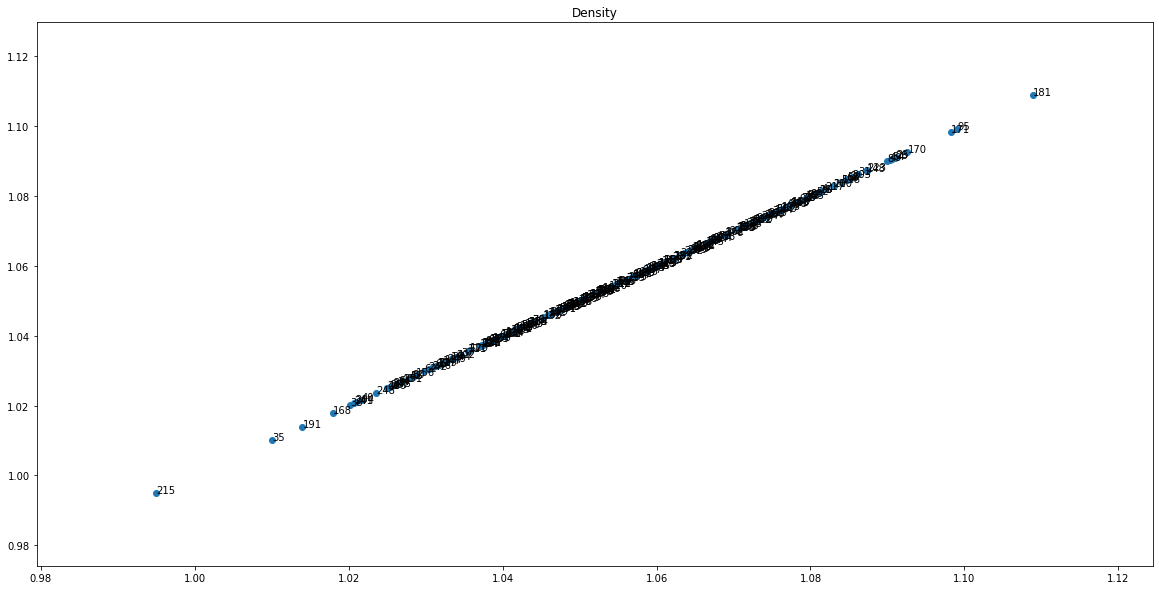

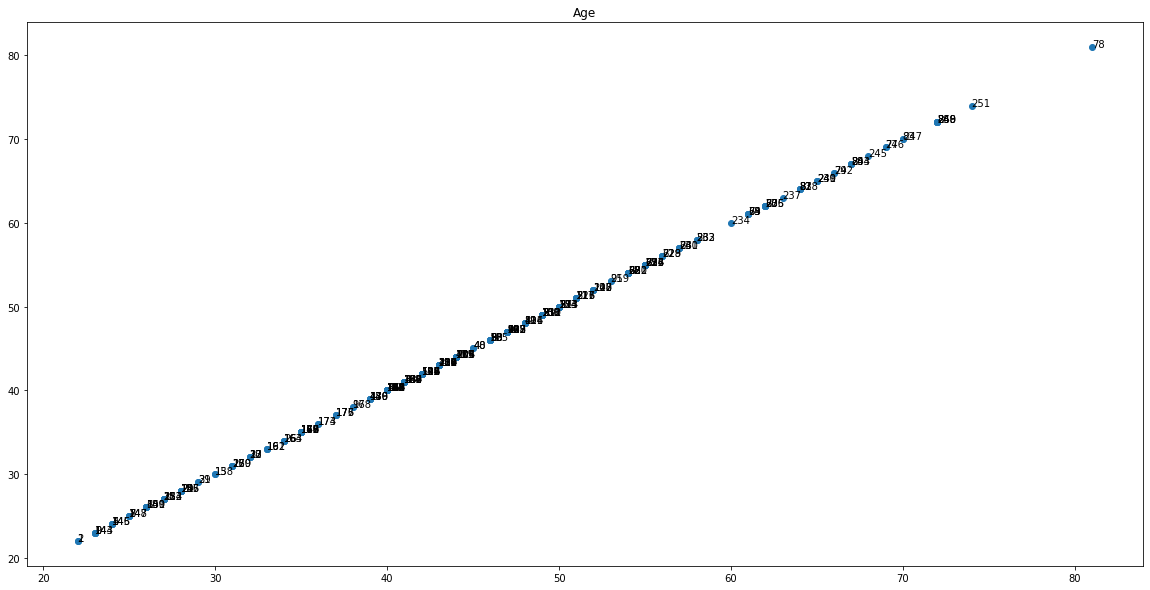

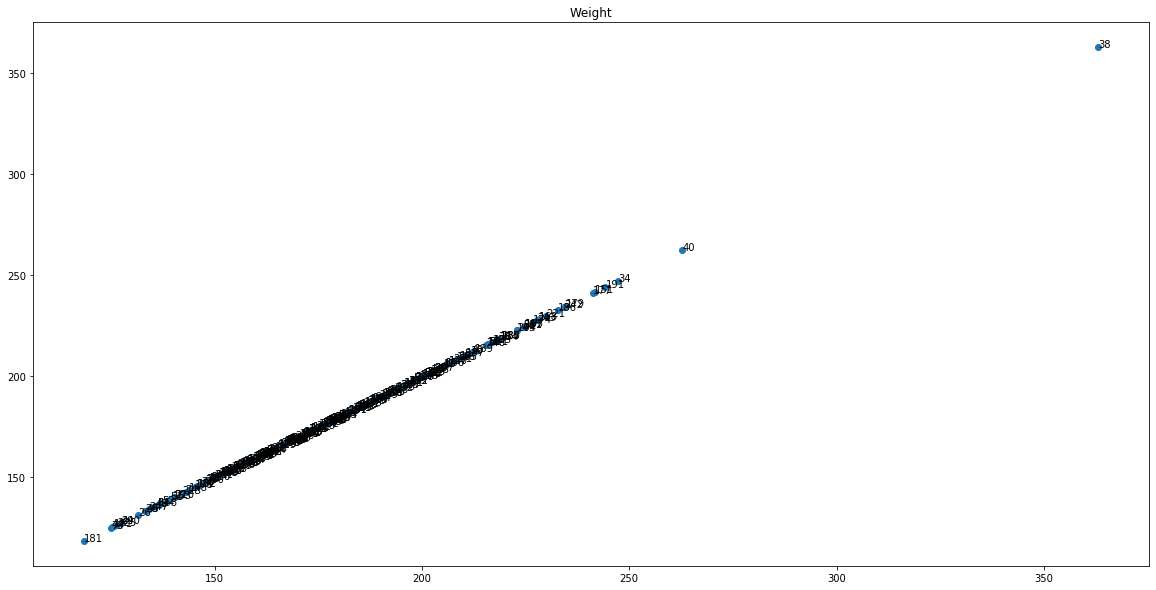

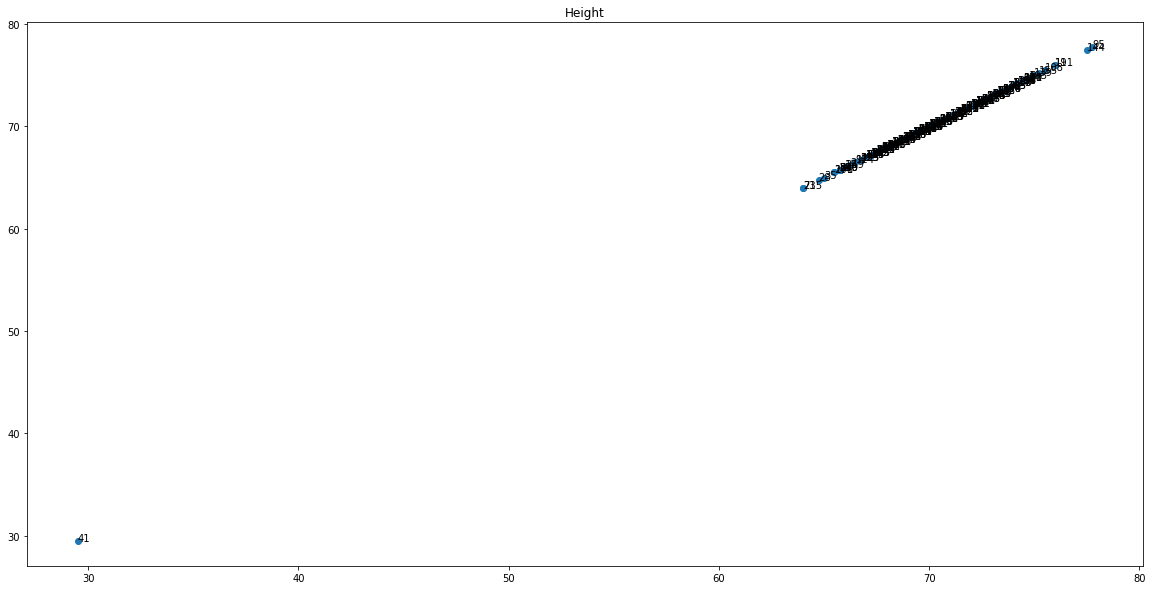

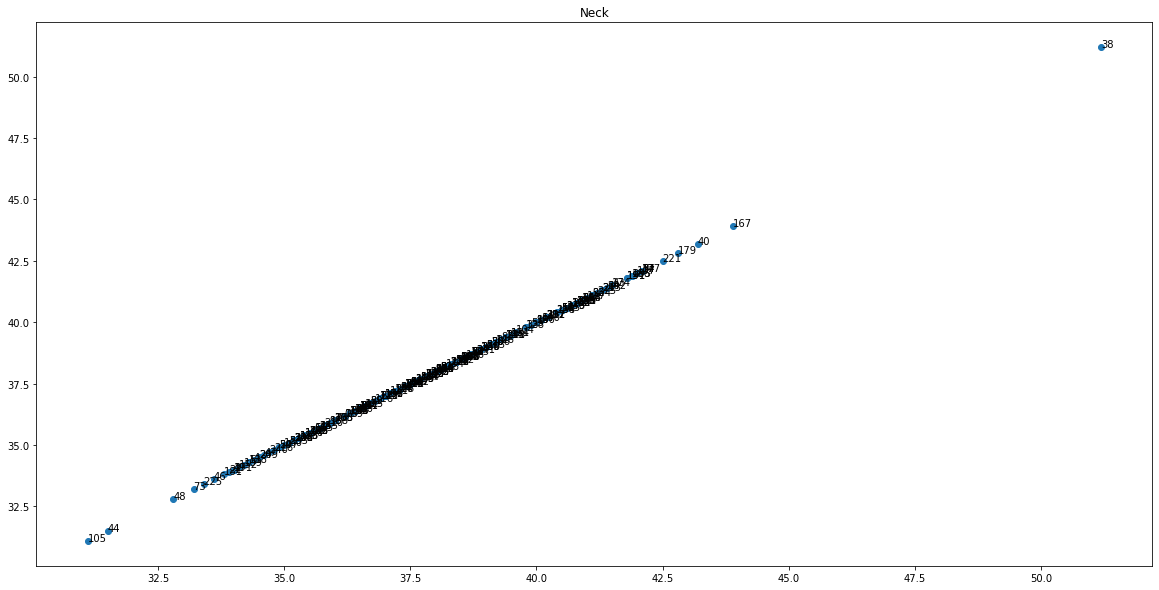

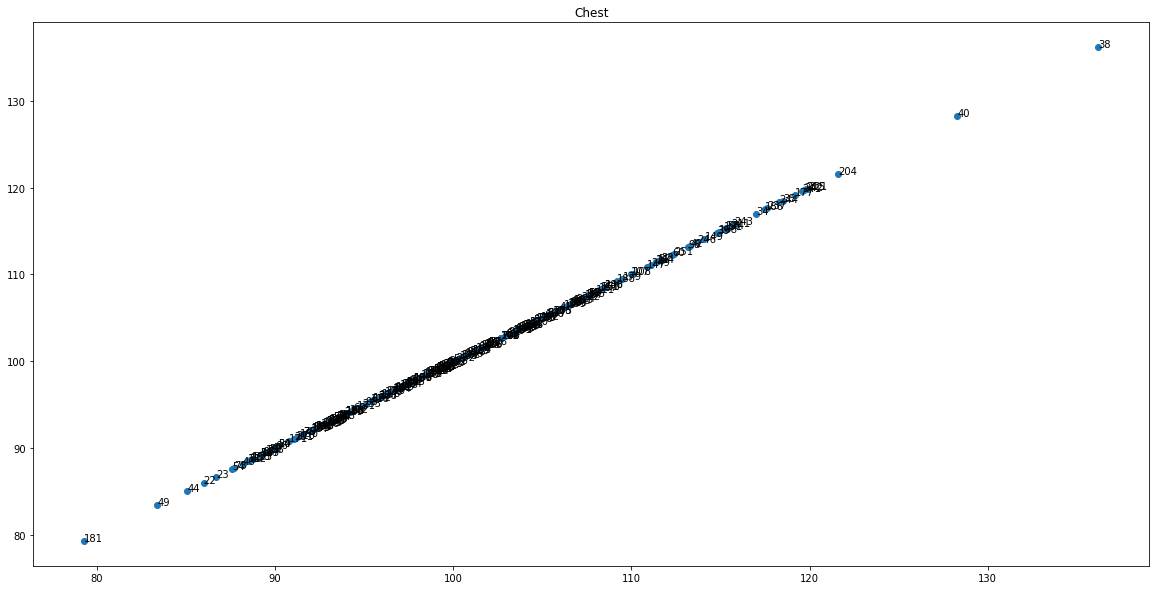

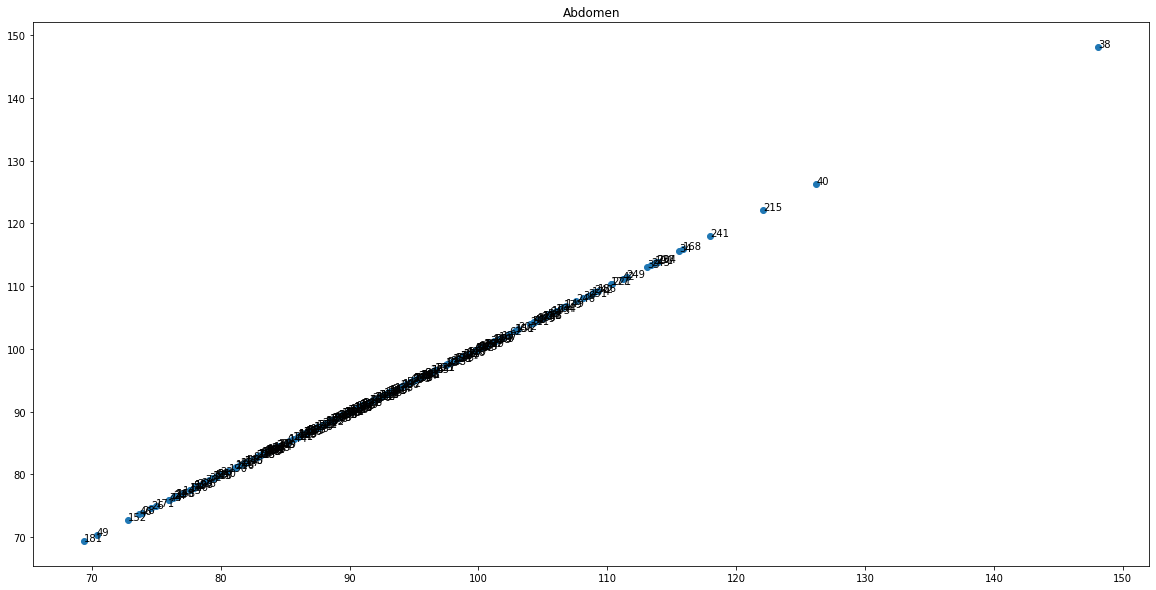

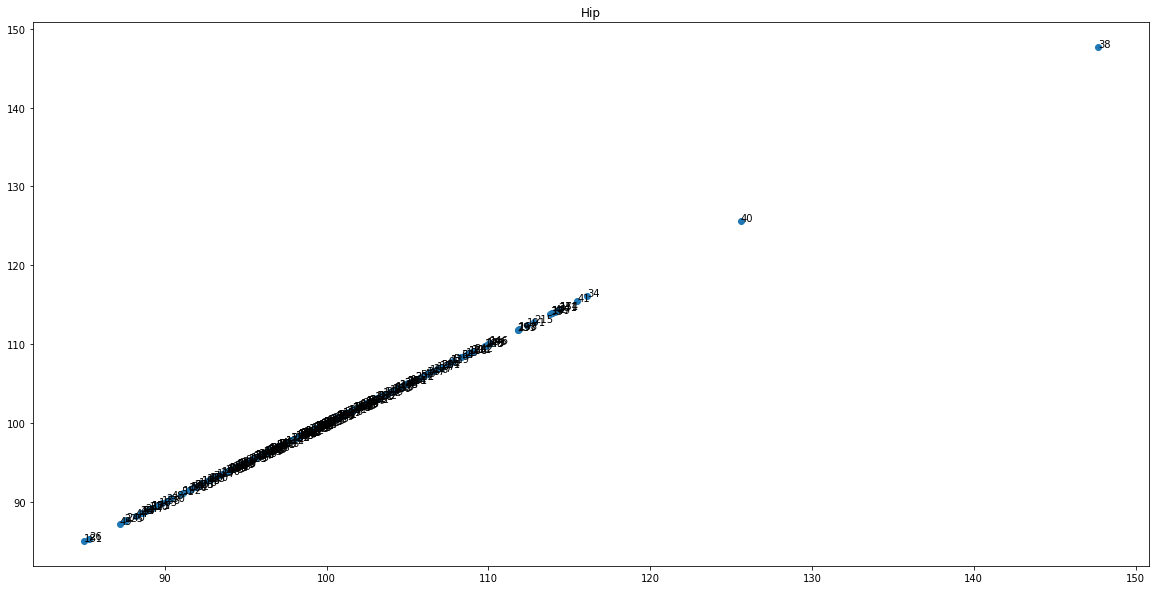

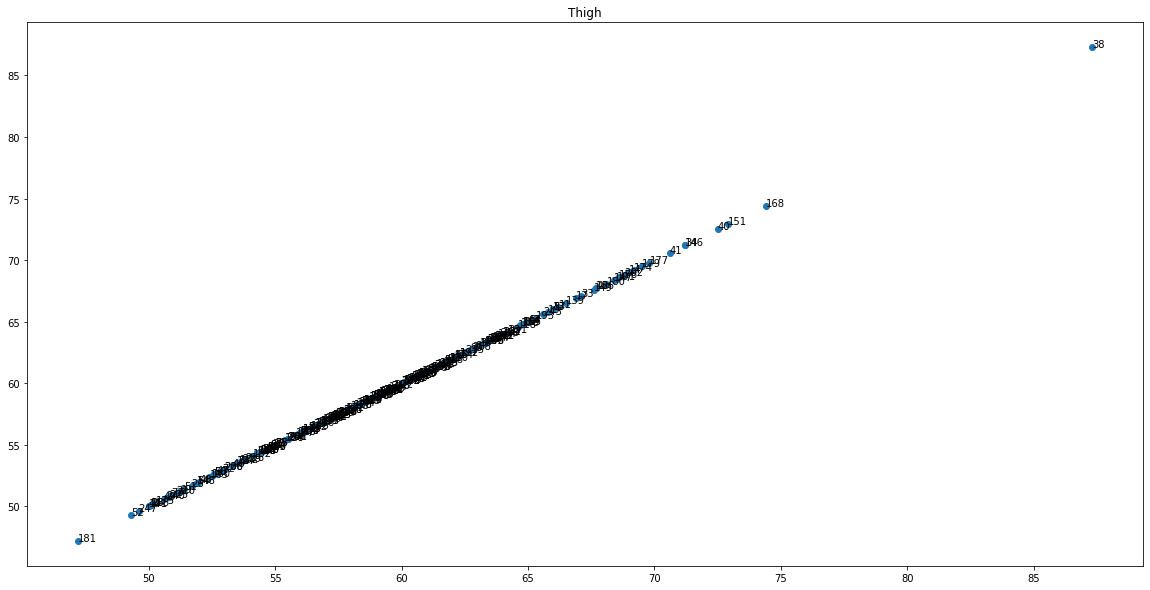

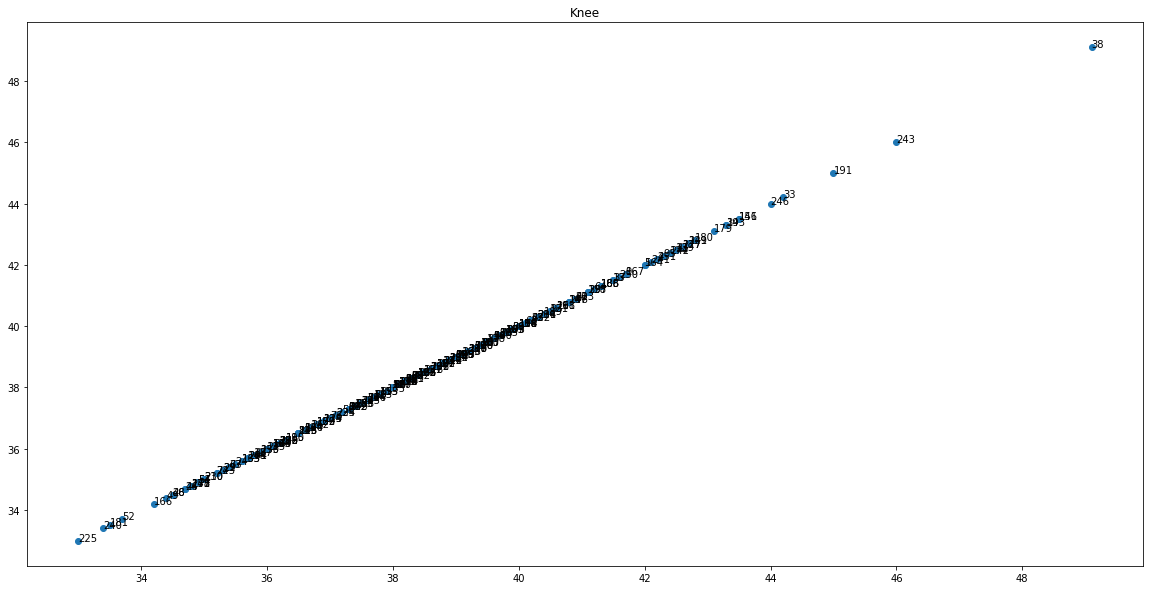

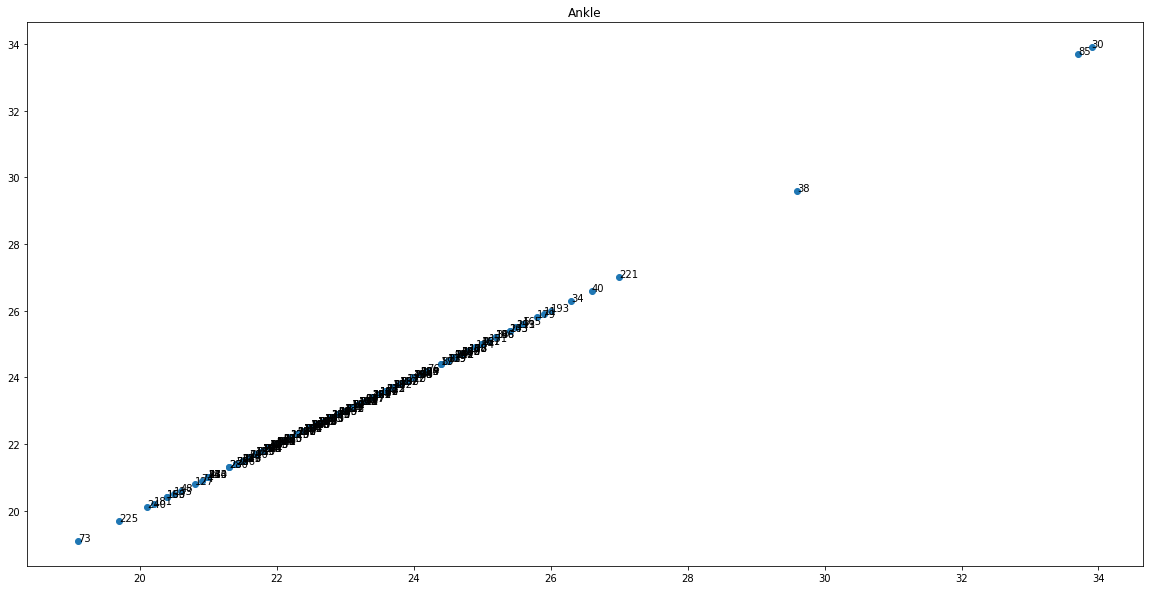

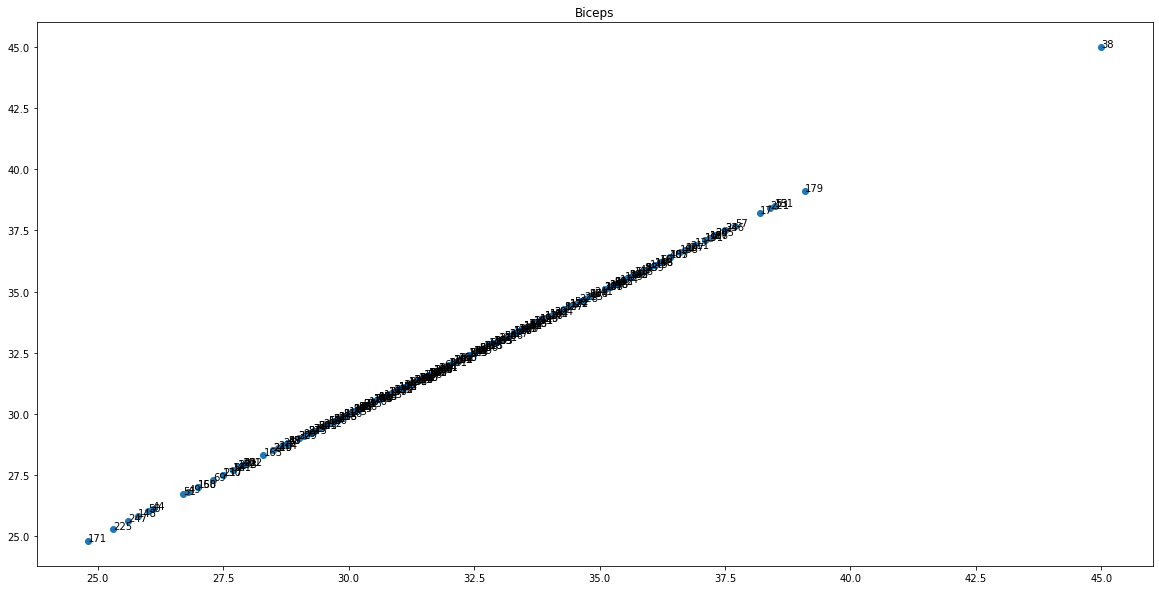

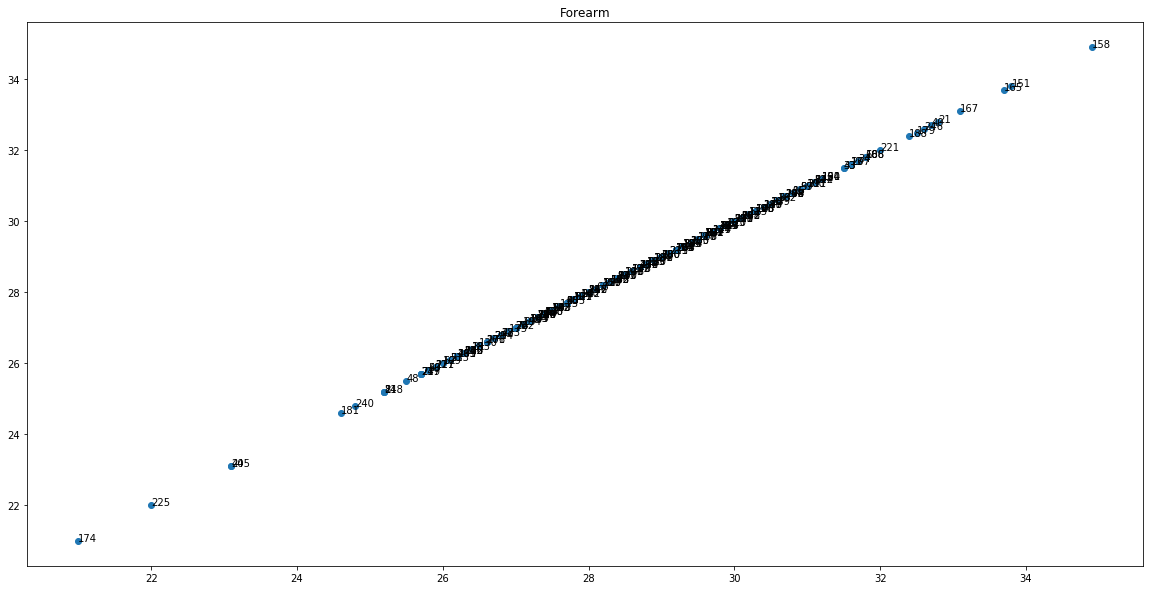

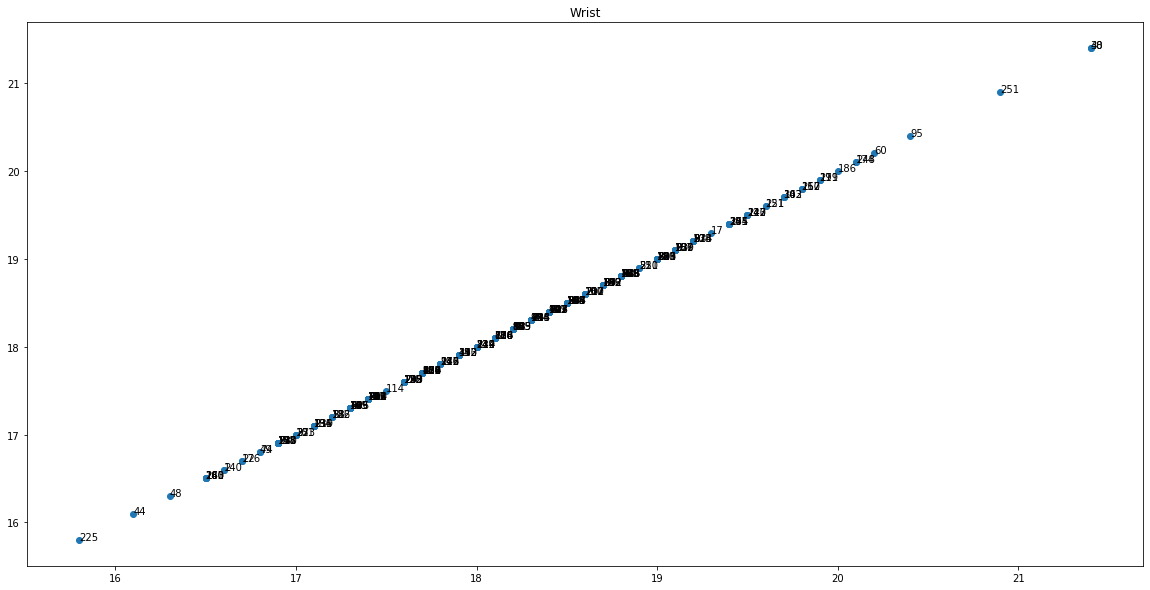

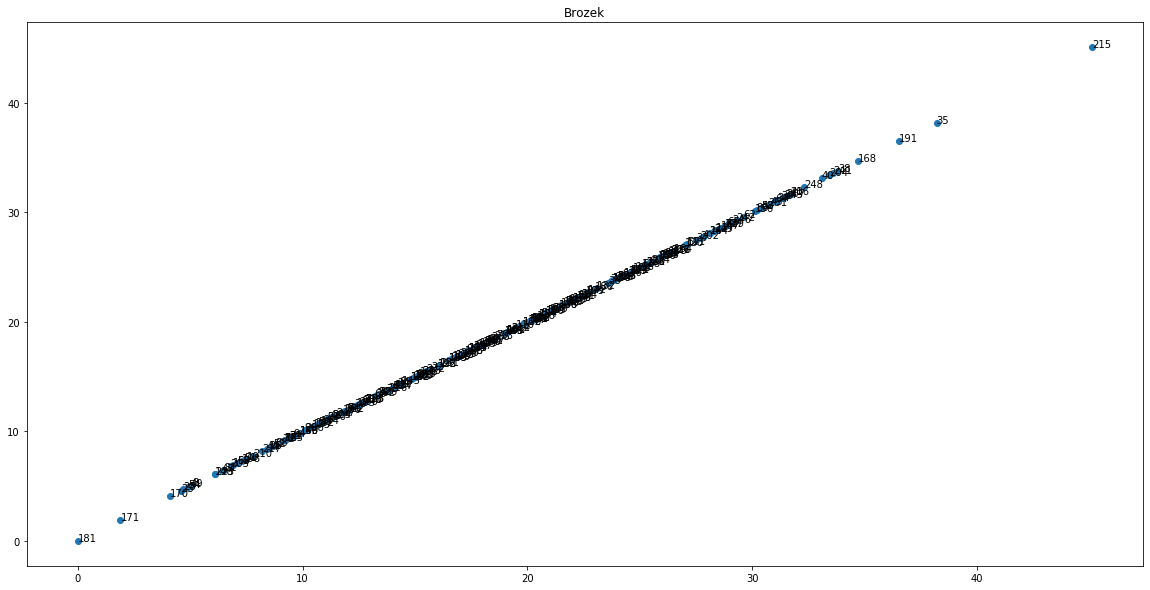

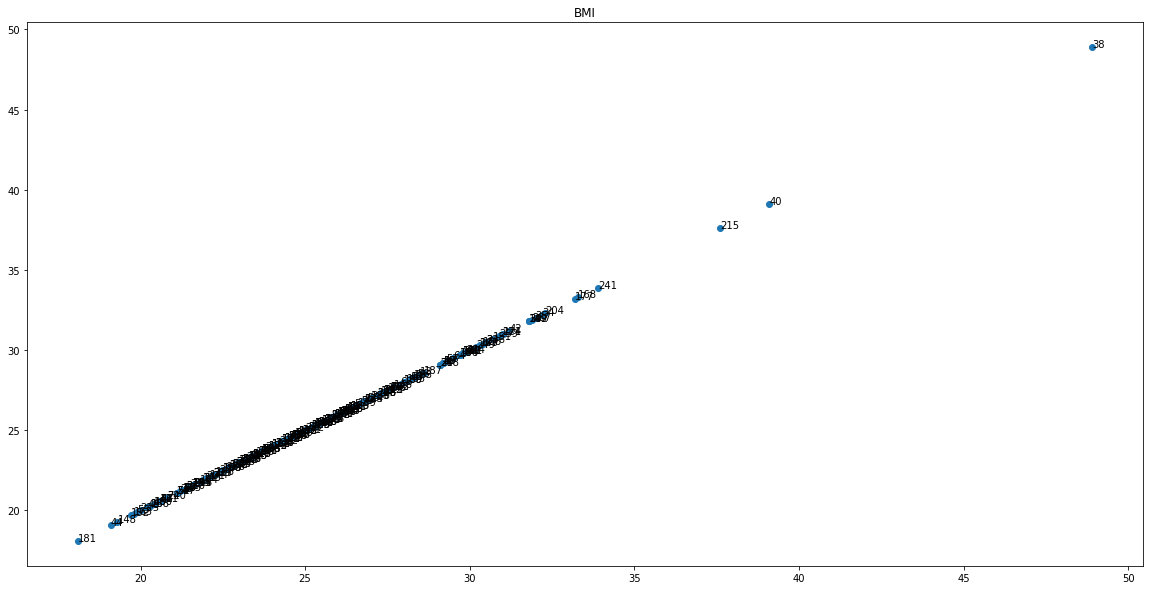

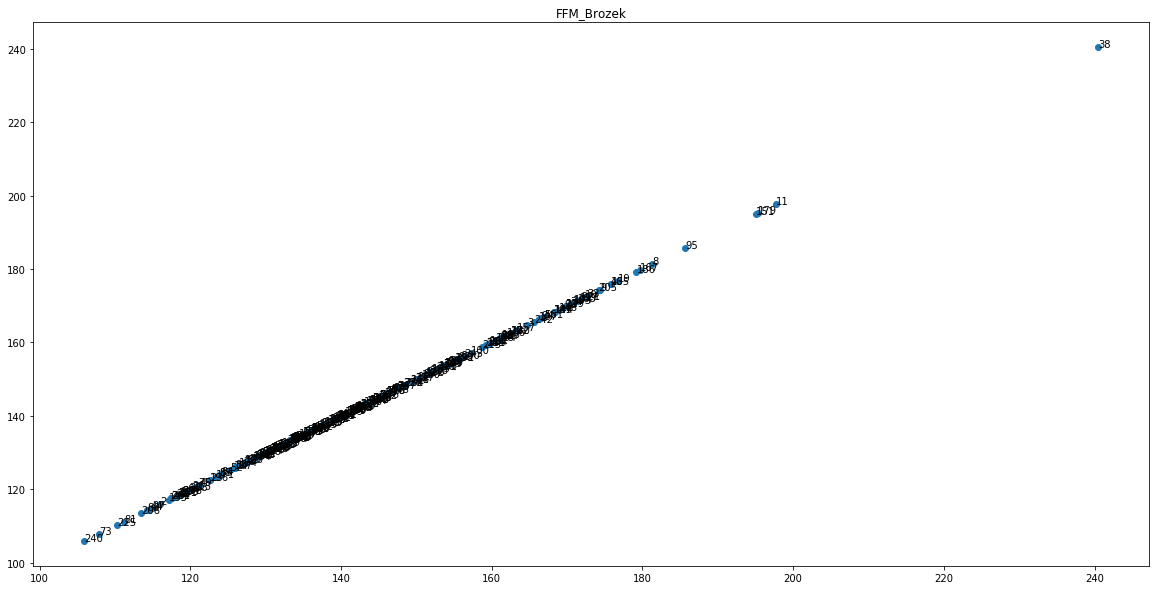

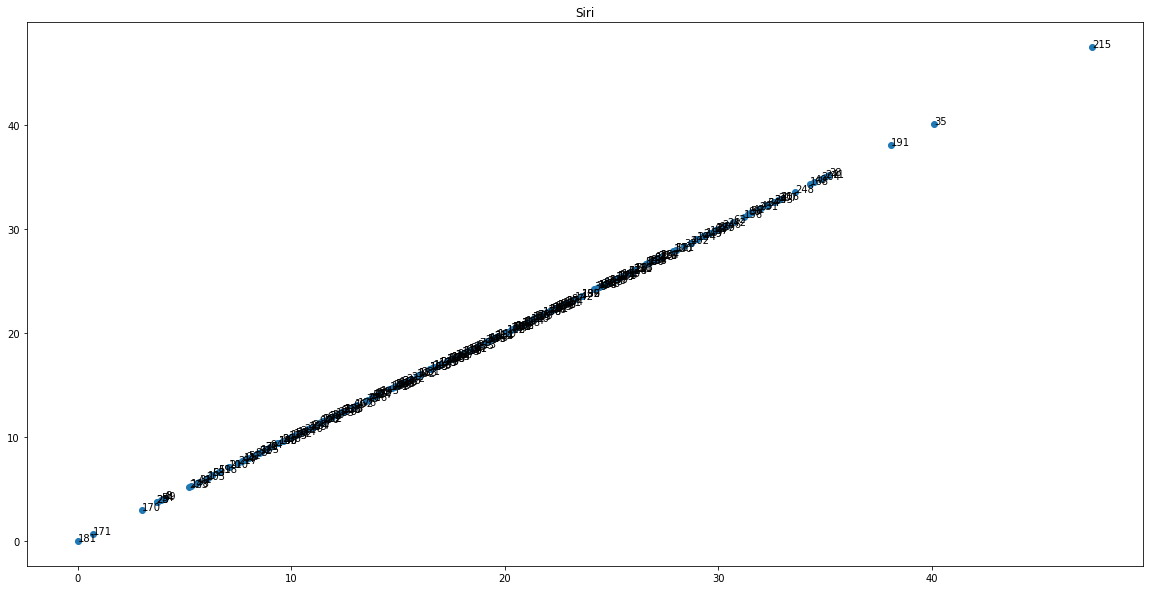

In [14]:
for x in list(df.columns):
    fig, ax = plt.subplots()
    plt.scatter(df[x], df[x])
    plt.title(x)
    for i in df.index:
        ax.annotate(i, (df[x][i], df[x][i]))
    plt.gcf().set_size_inches((20, 10))   
    plt.show();

In [15]:
# 181, 215, 191, 171, 78, 38, 41, 30, 85, 40, 168, 35 adding to list to be reviewed
list1 = [181, 215, 191, 171, 78, 38, 41, 30, 85, 40, 168, 35]
list_creator(list1)

[181, 215, 191, 171, 78, 38, 41, 30, 85, 40, 168, 35]

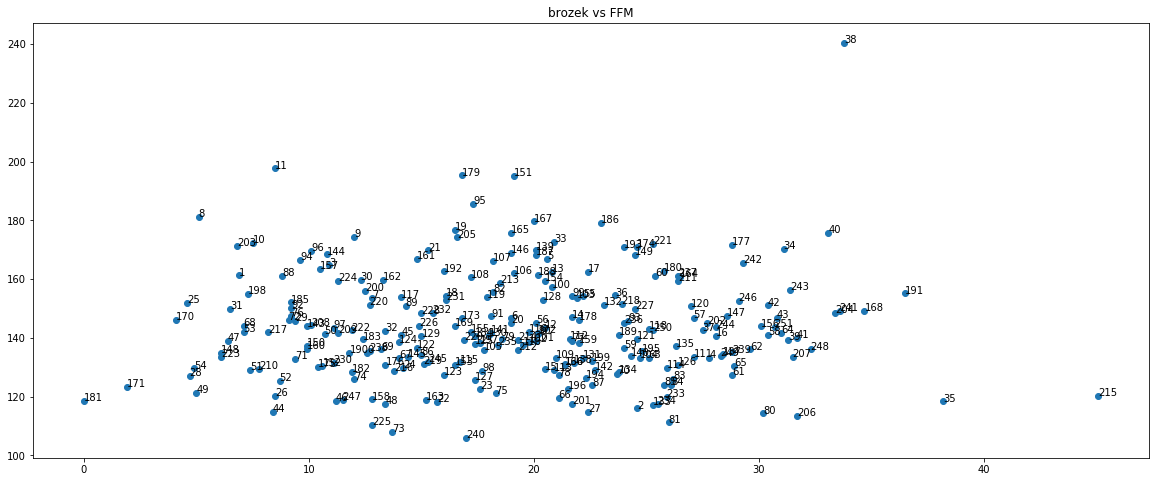

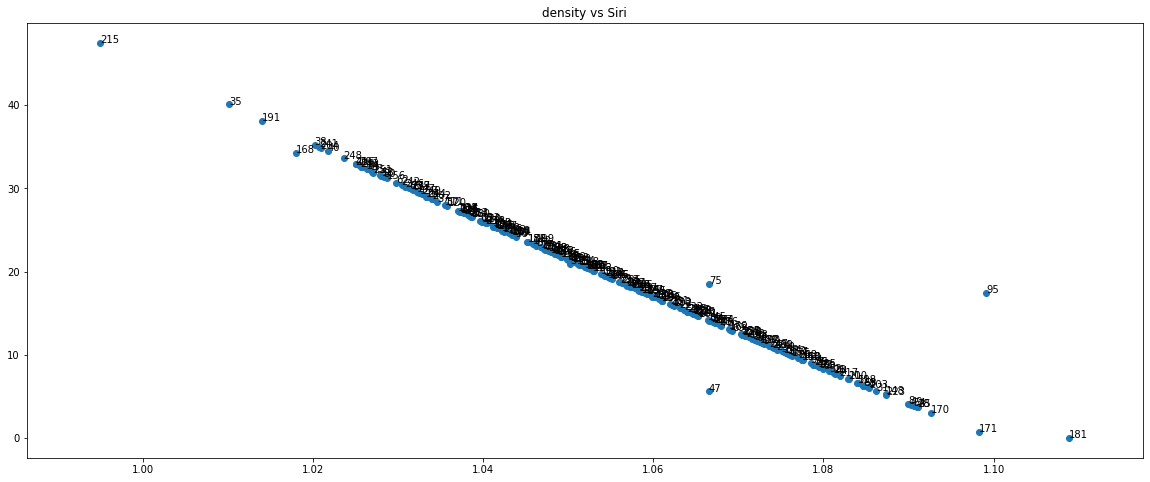

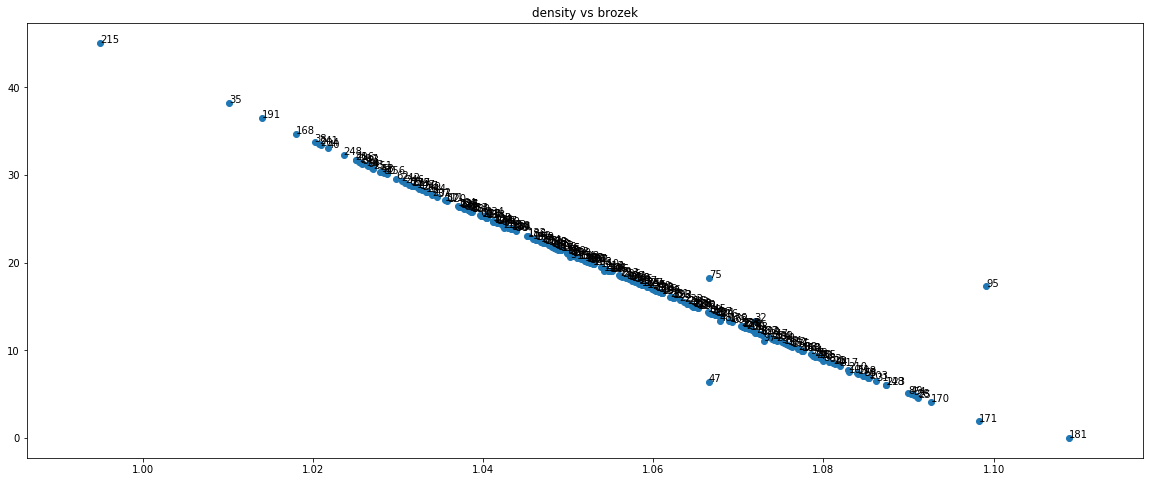

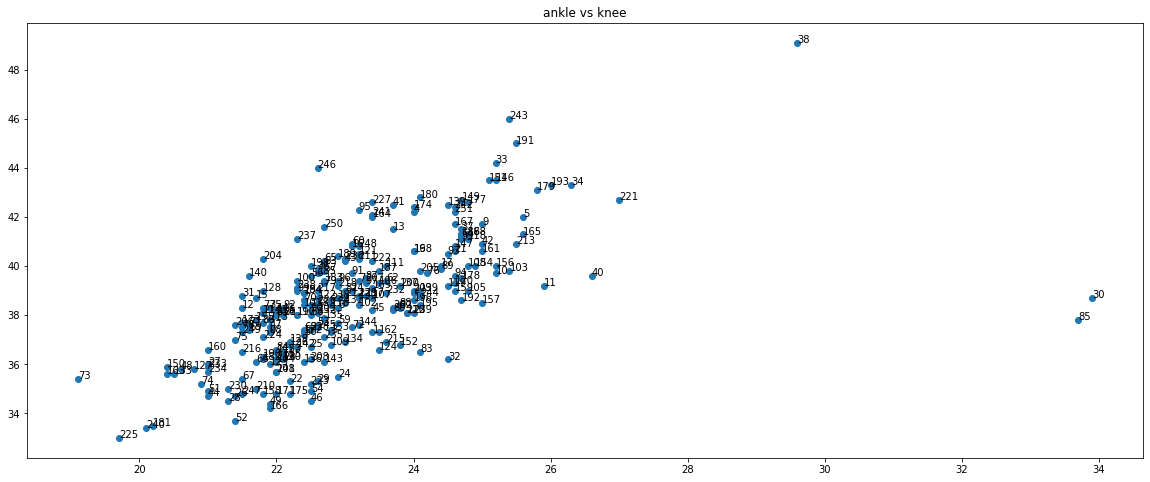

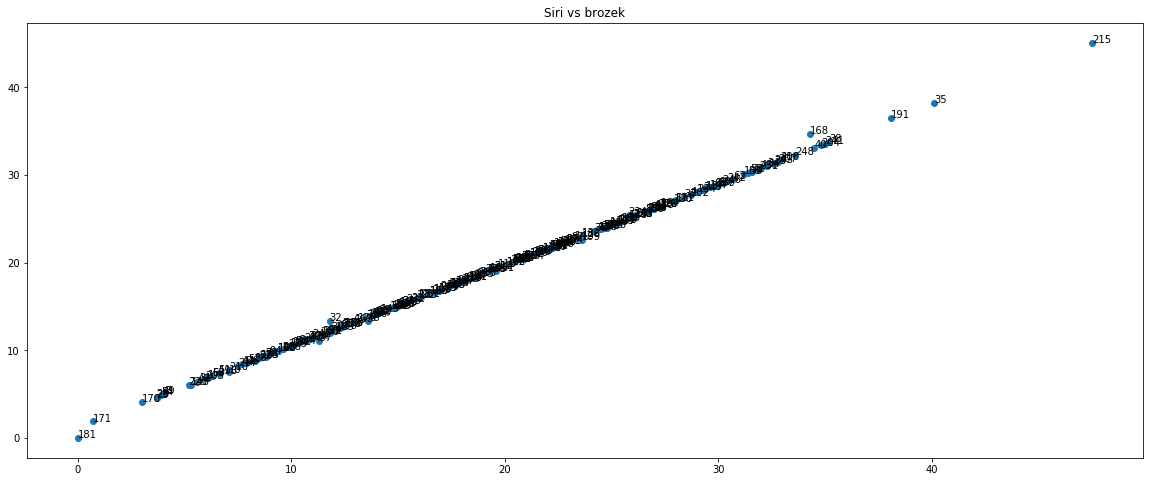

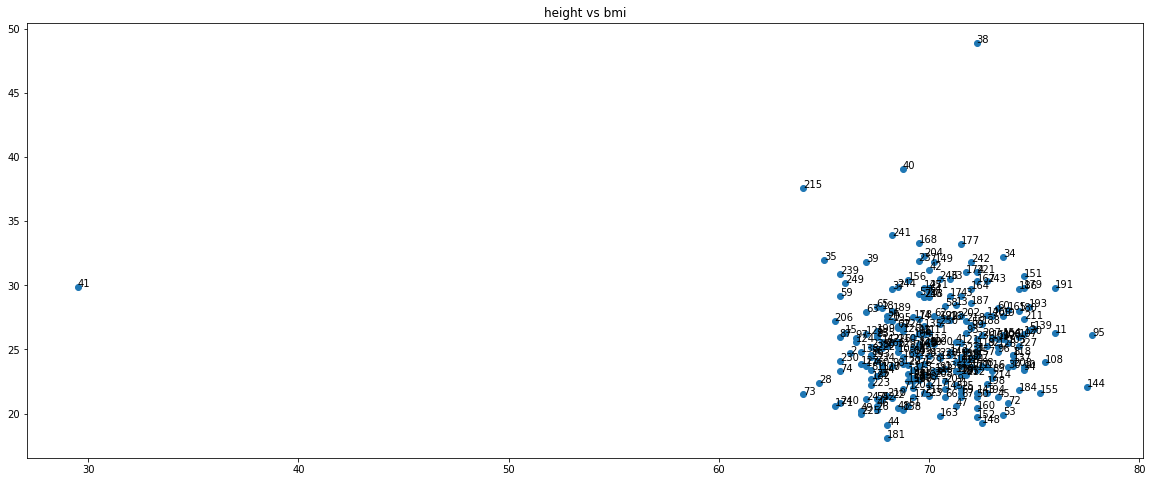

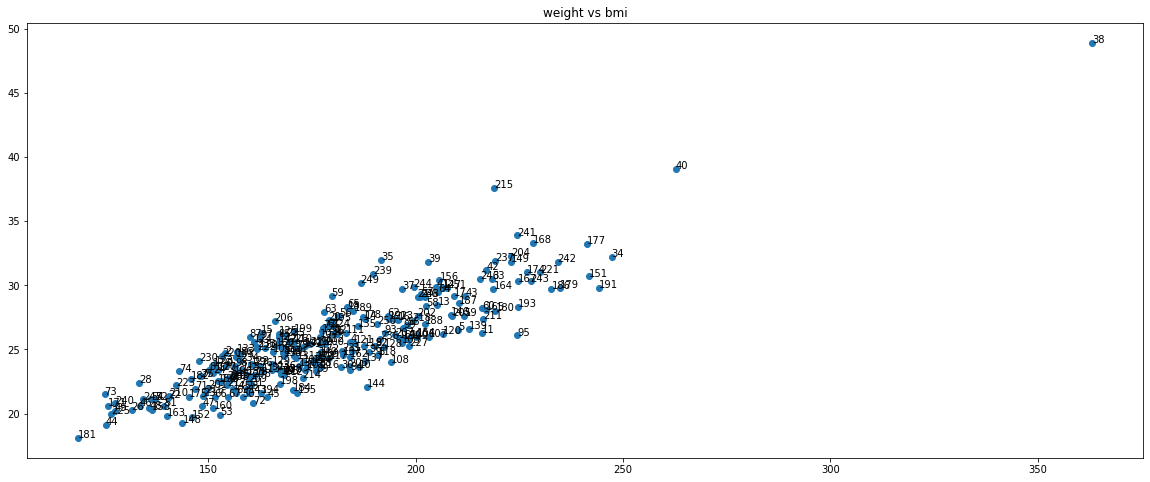

In [16]:
columns = [(df['Brozek'], df['FFM_Brozek']), (df['Density'], df['Siri']), (df['Density'], df['Brozek']),
          (df['Ankle'], df['Knee']), (df['Siri'], df['Brozek']), (df['Height'], df['BMI']), (df['Weight'], df['BMI'])]
column_names = ['brozek vs FFM', 'density vs Siri', 'density vs brozek', 'ankle vs knee', 'Siri vs brozek', 'height vs bmi', 'weight vs bmi']

total = 0
for z in columns:
    total2 = 0
    list1 = []
    list2 = []
    for i in z[0]:
        list1.append(i)
    for i in z[1]:
        list2.append(i)
    list3 = zip(list1, list2)
    fig, ax = plt.subplots(figsize=(20,8))
    plt.title(column_names[total])
    total += 1
    ax.scatter(z[0], z[1])
    for x,y in list3:
        ax.annotate(total2, (x, y))
        total2 += 1
    plt.show();

In [17]:
#38, 215, 95, 47 add to review list
list2 = [38, 215, 95, 47, 168, 32]
list_creator(list2)

[181, 215, 191, 171, 78, 38, 41, 30, 85, 40, 168, 35, 38, 215, 95, 47, 168, 32]

In [18]:
#sn.pairplot(df, diag_kind = 'kde', height=4);
#plt.show();

In [19]:
# Ankle greater than 30 (2 samples have much larger ankles than even the heaviest weighing sample)
# FFM larger than 220 (extreme outlier)

In [20]:
print(df[df['Ankle'] > 30]) #30, 85, 
print(df[df['FFM_Brozek'] > 220]) #38
print(df[df['Age'] > 80]) #78 (out of population sample),
print(df[df['Brozek'] < 3]) #181, 171 (cannot live with less than 2-5% BF and these men are older)
print(df[df['Height'] < 60]) #41 (unrealistic height)
print(df[df['Weight'] > 300]) #38 (extremely obese, out of population sample))

    Density  Age  Weight  Height  Neck  Chest  Abdomen   Hip  Thigh  Knee  \
30   1.0716   32   182.0   73.75  38.7  100.5     88.7  99.8   57.5  38.7   
85   1.0386   67   167.0   67.50  36.5   98.9     89.7  96.2   54.7  37.8   

    Ankle  Biceps  Forearm  Wrist  Brozek   BMI  FFM_Brozek  Siri  
30   33.9    32.5     27.7   18.4    12.3  23.6       159.7  11.9  
85   33.7    32.4     27.7   18.2    25.8  26.0       123.9  26.6  
    Density  Age  Weight  Height  Neck  Chest  Abdomen    Hip  Thigh  Knee  \
38   1.0202   46  363.15   72.25  51.2  136.2    148.1  147.7   87.3  49.1   

    Ankle  Biceps  Forearm  Wrist  Brozek   BMI  FFM_Brozek  Siri  
38   29.6    45.0     29.0   21.4    33.8  48.9       240.5  35.2  
    Density  Age  Weight  Height  Neck  Chest  Abdomen   Hip  Thigh  Knee  \
78   1.0498   81  161.25   70.25  37.8   96.4     95.4  99.3   53.5  37.5   

    Ankle  Biceps  Forearm  Wrist  Brozek   BMI  FFM_Brozek  Siri  
78   21.5    31.4     26.8   18.3    21.1  23.0 

In [21]:
list3 = [30,85,78, 38,181,187, 41,38]
list_creator(list3)

[181,
 215,
 191,
 171,
 78,
 38,
 41,
 30,
 85,
 40,
 168,
 35,
 38,
 215,
 95,
 47,
 168,
 32,
 30,
 85,
 78,
 38,
 181,
 187,
 41,
 38]

In [22]:
#samples that have been marked as incorrect BF calculations by the person uploaded this dataset
list4 = [48,76,96]
list_creator(list4)

[181,
 215,
 191,
 171,
 78,
 38,
 41,
 30,
 85,
 40,
 168,
 35,
 38,
 215,
 95,
 47,
 168,
 32,
 30,
 85,
 78,
 38,
 181,
 187,
 41,
 38,
 48,
 76,
 96]

In [23]:
#Function to frame all samples for review
def review(list, df, new_df):
    z = set(list)
    extra_df = pd.DataFrame()
    for x in z:
        a = df.loc[x]
        b = pd.DataFrame(a)
        frames = [extra_df, b]
        extra_df = pd.concat(frames, axis=1)
    return extra_df.T

In [24]:
review_df = pd.DataFrame()
review_df = review(review_list, df, review_df)
review_df

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,Brozek,BMI,FFM_Brozek,Siri
32,1.0719,27.0,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,13.4,23.3,142.5,11.8
96,1.0770,38.0,188.75,73.25,37.5,99.1,91.6,102.4,60.6,39.4,22.9,31.6,30.1,18.5,10.1,24.8,169.6,9.6
35,1.0101,49.0,191.75,65.00,38.4,118.5,113.1,113.8,61.9,38.3,21.9,32.0,29.8,17.0,38.2,32.0,118.4,40.1
38,1.0202,46.0,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,33.8,48.9,240.5,35.2
40,1.0217,45.0,262.75,68.75,43.2,128.3,126.2,125.6,72.5,39.6,26.6,36.4,32.7,21.4,33.1,39.1,175.8,34.5
41,1.0250,44.0,205.00,29.50,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4,31.7,29.9,140.1,32.9
168,1.0180,35.0,228.25,69.50,40.4,114.9,115.9,111.9,74.4,40.6,24.0,36.1,31.8,18.8,34.7,33.3,149.3,34.3
171,1.0983,35.0,125.75,65.50,34.0,90.8,75.0,89.2,50.0,34.8,22.0,24.8,25.9,16.9,1.9,20.6,123.4,0.7
76,1.0790,57.0,162.50,69.50,38.7,91.6,78.8,94.3,56.7,39.7,24.2,30.2,29.2,18.1,9.2,23.7,147.5,8.8
78,1.0498,81.0,161.25,70.25,37.8,96.4,95.4,99.3,53.5,37.5,21.5,31.4,26.8,18.3,21.1,23.0,127.2,21.5


In [25]:
drop_list = [181, 171, 41, 215, 35, 40,  168, 30, 78, 38, 48, 76, 96]
review_df.drop(drop_list, axis=0, inplace=True)

In [26]:
df.drop(drop_list, axis=0, inplace=True)

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,Brozek,BMI,FFM_Brozek,Siri
32,1.0719,27.0,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,13.4,23.3,142.5,11.8
47,1.0665,39.0,148.50,71.25,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9,6.4,20.6,139.0,5.6
95,1.0991,53.0,224.50,77.75,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4,17.3,26.1,185.7,17.4
85,1.0386,67.0,167.00,67.50,36.5,98.9,89.7,96.2,54.7,37.8,33.7,32.4,27.7,18.2,25.8,26.0,123.9,26.6
187,1.0524,41.0,210.50,72.00,38.5,107.4,98.9,104.1,63.5,39.8,23.5,36.4,30.4,19.1,20.1,28.6,168.3,20.4
191,1.0140,42.0,244.25,76.00,41.8,115.2,113.7,112.4,68.5,45.0,25.5,37.1,31.2,19.9,36.5,29.8,155.2,38.1


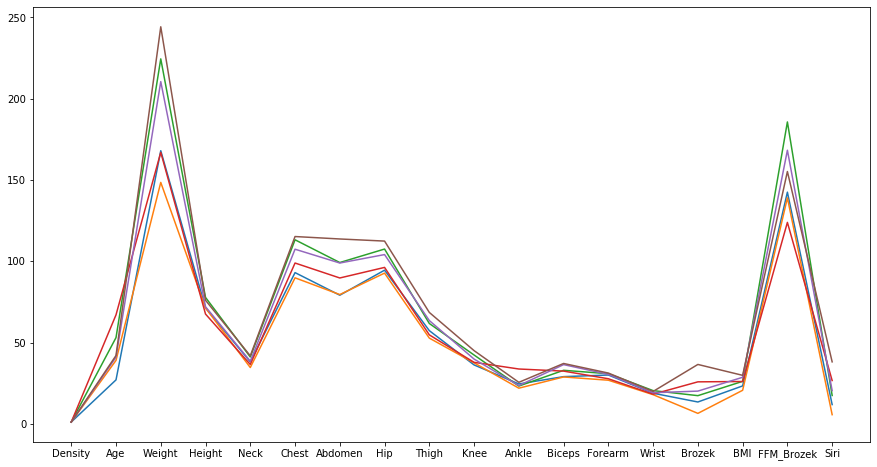

In [27]:
fig = plt.figure(figsize=(15,8))
index = list(review_df.index)
for x in index:
    plt.plot(review_df.loc[x])
review_df

In [28]:
## 171 and 181 have estimated bf percentages lower than 2%, which is required for life. I can either remove these as inaccurate or test a model 
## increasing the estimate bf by 2 for all. I would like to find the measurements responsible for the inaccuracies and maybe remove or alter
## them for a model.

In [29]:
## Should I remove the two Obese measurements? With there only being 2 will it negatively impact my model?

In [30]:
## check all density within a certain range

## Feature Engineering

In [31]:
## the formula used by the DoD is 86.010 x log10(abdomen - neck) - 70.041 x log10(height) + 36.76
# Creating a copy dataset only including the 3 variables used in the DOD measurement 
# Im going to change the measurements to inches for the equation
df3 = df[['Height', 'Neck', 'Abdomen']].copy()

df3['Neck'] = df3['Neck'] * 0.393701
df3['Abdomen'] = df3['Abdomen'] * 0.393701

df3

,Height,Neck,Abdomen
0,67.75,14.251976,33.543325
1,72.25,15.157489,32.677183
2,66.25,13.385834,34.606318
3,72.25,14.724417,34.015766
4,71.25,13.543314,39.370100
...,...,...,...
247,67.00,13.740165,32.913404
248,69.75,16.102371,41.338605
249,66.00,15.314969,43.897662
250,70.50,15.314969,39.881911


In [32]:
#Using the DoD formula against all samples to create a list of body fat percentages and then adding it as a column to df3

bf = []
ans1 = []
ans2 = []

for x in df3['Height']:
    ans2.append(np.log10(x))

for x in df3['Abdomen']:
    for y in df3['Neck']:
        ans1.append(np.log10(x-y))
        
answers = zip(ans1, ans2)

for x, y in answers:
    bf.append(round(86.010 * x - 70.041 * y + 36.76, 2))
print(bf)

df3['DoD_BF'] = bf
df3['Brozek'] = df['Brozek']
df3

[19.08, 15.32, 21.4, 16.19, 18.89, 13.89, 18.04, 15.77, 14.91, 11.81, 14.39, 13.06, 16.58, 15.02, 14.87, 19.72, 15.53, 12.86, 17.68, 13.58, 16.68, 14.08, 20.57, 18.61, 20.35, 17.82, 19.19, 17.15, 20.3, 18.14, 16.7, 16.07, 14.8, 11.81, 16.29, 14.06, 16.23, 17.23, 13.16, 22.38, 17.08, 21.12, 18.74, 21.17, 18.1, 19.94, 18.85, 17.43, 17.95, 14.29, 16.68, 14.87, 14.33, 18.27, 12.51, 19.2, 16.58, 18.49, 14.98, 15.42, 18.21, 16.9, 17.4, 17.36, 17.97, 16.67, 16.34, 23.03, 19.76, 19.34, 16.78, 17.48, 17.36, 17.82, 14.47, 16.13, 16.61, 18.96, 18.14, 19.76, 15.62, 16.42, 17.31, 15.94, 16.86, 15.93, 15.34, 10.95, 17.69, 19.08, 14.21, 13.5, 16.61, 17.47, 12.9, 15.72, 22.44, 14.72, 11.58, 13.98, 19.9, 17.97, 17.39, 14.9, 18.65, 15.93, 18.33, 16.45, 13.37, 14.75, 15.72, 12.5, 14.83, 18.09, 18.99, 18.48, 19.11, 16.51, 18.07, 13.85, 16.55, 17.97, 17.79, 15.46, 18.29, 18.07, 16.95, 17.14, 15.23, 18.96, 12.3, 16.72, 18.07, 18.07, 17.65, 13.59, 18.14, 14.55, 14.42, 17.77, 14.46, 19.12, 11.65, 18.69, 17.98

,Height,Neck,Abdomen,DoD_BF,Brozek
0,67.75,14.251976,33.543325,19.08,12.6
1,72.25,15.157489,32.677183,15.32,6.9
2,66.25,13.385834,34.606318,21.40,24.6
3,72.25,14.724417,34.015766,16.19,10.9
4,71.25,13.543314,39.370100,18.89,27.8
...,...,...,...,...,...
247,67.00,13.740165,32.913404,20.39,11.5
248,69.75,16.102371,41.338605,14.42,32.3
249,66.00,15.314969,43.897662,17.75,28.3
250,70.50,15.314969,39.881911,15.75,25.3


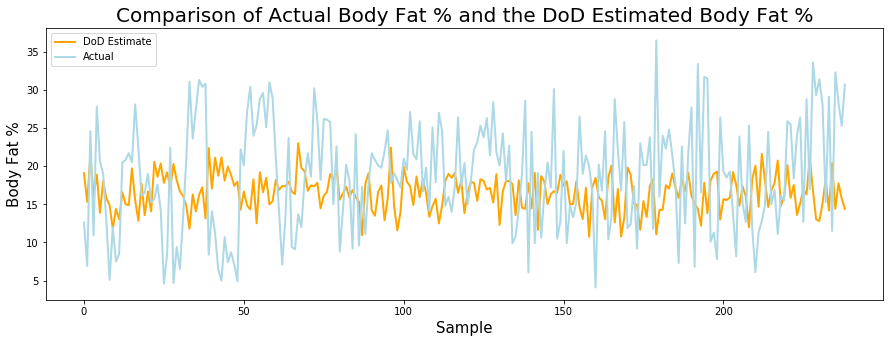

In [167]:
x = range(0,239)
y1 = df3['DoD_BF']
y2 = df3['Brozek']

plt.figure(figsize=(15, 5))
plt.plot(x, y1, color='orange', linewidth=2, label='DoD Estimate')
plt.plot(x, y2, color='lightblue', linewidth=2, label='Actual')
plt.title('Comparison of Actual Body Fat % and the DoD Estimated Body Fat %', fontsize=20)
plt.ylabel('Body Fat %', fontsize=15)
plt.xlabel('Sample', fontsize=15)
plt.legend()
plt.savefig("BF_comparison.png")
plt.show();

In [33]:
# Adding a colummn for the error between actual and DoD measurement
df3['Error'] = df3['DoD_BF'] - df3['Brozek']
df['Error'] = df3['Error']
df

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,Brozek,BMI,FFM_Brozek,Siri,Error
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9,12.3,6.48
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9,23.4,161.3,6.1,8.42
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0,25.3,-3.20
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7,10.4,5.29
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1,28.7,-8.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.5,21.1,118.9,11.0,8.89
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,32.3,29.1,136.1,33.6,-17.88
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,28.3,30.2,133.9,29.3,-10.55
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,25.3,27.0,142.6,26.0,-9.55


In [34]:
## Creating a column for wrist measurement in inches form centimeters and then to create a column for body frame size based on that measurement. 
## See readme for body frame category measurements

#df['Wrist_Inches'] = round(df['Wrist'] * 0.393701,2)

In [35]:
## Creating the frame column

#wrist_inches = pd.array(df['Wrist_Inches'])

In [36]:
## Going to use -1 for small, 0 for medium, and 1 for large frames

#frame = []

#for x in wrist_inches:
    #if x > 7.5:
        #frame.append(1)
    #elif x <= 7.5 and x >= 6.5:
        #frame.append(0)
    #else:
        #frame.append(-1)

In [37]:
## adding the frame column
#df['Frame'] = DataFrame(frame, columns=['Frame'])

In [38]:
df

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,Brozek,BMI,FFM_Brozek,Siri,Error
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9,12.3,6.48
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9,23.4,161.3,6.1,8.42
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0,25.3,-3.20
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7,10.4,5.29
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1,28.7,-8.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.5,21.1,118.9,11.0,8.89
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,32.3,29.1,136.1,33.6,-17.88
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,28.3,30.2,133.9,29.3,-10.55
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,25.3,27.0,142.6,26.0,-9.55


In [39]:
#df['Comined_ratio'] = 
df['Abs_chest_hips'] = df['Abdomen'] / (df['Chest'] + df['Thigh'])

In [40]:
# the majority of men carry fat mostly in their upper bodies, lest test the ankle to their thigh and wrist to abdomen ratios

In [41]:
#side note i wonder if the breadth/circumference ratio can predict body fat also maybe when flexed (ex. measuring height of
#muscle in bicep in ratio to the circuference around when flexed, breadth of forearm vs circumference) fat would be more circular
#0.5/more muscle would be more oval 

In [42]:
df['HW_ratio'] = round(df['Abdomen'] / df['Hip'], 2)

In [43]:
df['abs_weight'] = round(df['Abdomen'] / df['Weight'], 2)

In [44]:
df['hip_weight'] = round(df['Hip'] / df['Weight'], 2)

In [45]:
df['abs_height'] = round(df['Abdomen'] / df['Height'], 2)

In [46]:
df['thigh_hip'] = round(df['Thigh'] / df['Hip'], 2)

In [47]:
df['thigh_abs'] = round(df['Thigh'] / df['Abdomen'], 2)

In [48]:
df['chest_abs'] = round(df['Chest'] / df['Abdomen'], 2)

In [49]:
df

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,Brozek,BMI,FFM_Brozek,Siri,Error,Abs_chest_hips,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9,12.3,6.48,0.560158,0.90,0.55,0.61,1.26,0.62,0.69,1.09
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,6.9,23.4,161.3,6.1,8.42,0.544977,0.84,0.48,0.57,1.15,0.59,0.71,1.13
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0,25.3,-3.20,0.565637,0.89,0.57,0.64,1.33,0.60,0.68,1.09
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7,10.4,5.29,0.533663,0.85,0.47,0.55,1.20,0.59,0.70,1.18
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1,28.7,-8.91,0.623053,0.98,0.54,0.55,1.40,0.62,0.63,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,1.0736,70,134.25,67.00,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.5,11.5,21.1,118.9,11.0,8.89,0.602305,0.94,0.62,0.66,1.25,0.56,0.59,1.07
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,32.3,29.1,136.1,33.6,-17.88,0.624628,1.00,0.52,0.52,1.51,0.57,0.57,1.03
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,28.3,30.2,133.9,29.3,-10.55,0.650525,1.10,0.60,0.54,1.69,0.59,0.54,1.00
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,25.3,27.0,142.6,26.0,-9.55,0.616555,1.04,0.53,0.51,1.44,0.57,0.55,1.07


## Analysis

In [50]:
# printing descriptive statistics on DOD BF ERROR for PPoint
print(abs(df3['Error']).mean())
print(abs(df3['Error']).min())
print(abs(df3['Error']).max())

7.227238493723849
0.030000000000001137
25.45


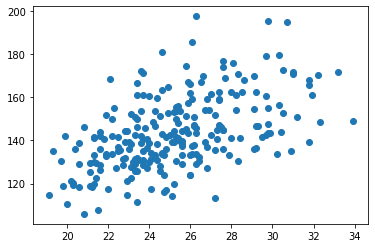

In [51]:
# correlation of BMI to FFM
plt.scatter(df['BMI'], df['FFM_Brozek'])

In [52]:
df[(df['Error'] < -8)]

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,Brozek,BMI,FFM_Brozek,Siri,Error,Abs_chest_hips,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,27.8,25.6,133.1,28.7,-8.91,0.623053,0.98,0.54,0.55,1.40,0.62,0.63,0.97
16,1.0333,34,195.75,71.00,38.9,101.9,96.4,105.2,64.8,40.8,23.1,36.2,30.8,17.3,28.1,27.3,140.8,29.0,-12.57,0.578284,0.92,0.49,0.54,1.36,0.62,0.67,1.06
17,1.0468,32,209.25,71.00,42.1,107.6,97.5,107.0,66.9,40.0,24.4,38.2,31.6,19.3,22.4,29.2,162.5,22.9,-9.54,0.558739,0.91,0.47,0.51,1.37,0.63,0.69,1.10
34,1.0263,41,247.25,73.50,42.1,117.0,115.6,116.1,71.2,43.3,26.3,37.3,31.7,19.7,31.1,32.2,170.4,32.3,-19.29,0.614240,1.00,0.47,0.47,1.57,0.61,0.62,1.01
37,1.0346,50,196.75,68.25,42.1,105.6,98.8,104.8,66.0,41.5,24.7,33.2,30.5,19.4,27.5,29.7,142.6,28.4,-13.44,0.575758,0.94,0.50,0.53,1.45,0.63,0.67,1.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,1.0308,69,215.50,70.50,40.8,113.7,107.6,110.0,63.3,44.0,22.6,37.5,32.6,18.8,29.1,30.5,152.7,30.2,-14.92,0.607910,0.98,0.50,0.51,1.53,0.58,0.59,1.06
248,1.0236,72,201.00,69.75,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.1,32.3,29.1,136.1,33.6,-17.88,0.624628,1.00,0.52,0.52,1.51,0.57,0.57,1.03
249,1.0328,72,186.75,66.00,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.0,28.3,30.2,133.9,29.3,-10.55,0.650525,1.10,0.60,0.54,1.69,0.59,0.54,1.00
250,1.0399,72,190.75,70.50,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.8,25.3,27.0,142.6,26.0,-9.55,0.616555,1.04,0.53,0.51,1.44,0.57,0.55,1.07


In [53]:
df[(df['Error'] > -8) & (df['Error'] < 8)]

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,Brozek,BMI,FFM_Brozek,Siri,Error,Abs_chest_hips,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,12.6,23.7,134.9,12.3,6.48,0.560158,0.90,0.55,0.61,1.26,0.62,0.69,1.09
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.6,24.7,116.0,25.3,-3.20,0.565637,0.89,0.57,0.64,1.33,0.60,0.68,1.09
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,10.9,24.9,164.7,10.4,5.29,0.533663,0.85,0.47,0.55,1.20,0.59,0.70,1.18
5,1.0502,24,210.25,74.75,39.0,104.5,94.4,107.8,66.0,42.0,25.6,35.7,30.6,18.8,20.6,26.5,167.0,20.9,-6.71,0.553666,0.88,0.45,0.51,1.26,0.61,0.70,1.11
6,1.0549,26,181.00,69.75,36.4,105.1,90.7,100.3,58.4,38.3,22.9,31.9,27.8,17.7,19.0,26.2,146.6,19.2,-0.96,0.554740,0.90,0.50,0.55,1.30,0.58,0.64,1.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,1.0384,58,161.75,67.25,35.1,94.9,94.9,100.2,56.8,35.9,21.0,27.8,26.1,17.6,25.9,25.2,119.9,26.7,-5.77,0.625577,0.95,0.59,0.62,1.41,0.57,0.60,1.00
235,1.0563,62,168.75,67.50,38.3,104.7,95.6,93.7,54.4,37.1,22.7,30.3,26.3,18.3,18.4,26.1,137.6,18.6,-0.85,0.600880,1.02,0.57,0.56,1.42,0.58,0.57,1.10
238,1.0705,64,155.25,69.50,37.9,95.8,82.8,94.5,61.2,39.1,22.3,29.8,28.9,18.3,12.7,22.6,135.5,12.4,4.28,0.527389,0.88,0.53,0.61,1.19,0.65,0.74,1.16
240,1.0599,65,127.50,65.75,34.7,93.0,79.7,87.6,50.7,33.4,20.1,28.5,24.8,16.5,17.0,20.8,105.9,17.0,4.11,0.554628,0.91,0.63,0.69,1.21,0.58,0.64,1.17


In [54]:
# Findings DoD underestimates low h/r and bmi, weight values 
# Dod overestimations have bmis higher than __ and h/r higher than __
# dod scores well on bmis around 24-26 and h/r 
# thigh/abs, chest/abs, biceps/abs all play a role
# men with higher actual BF than DOD had larger thighs 
# lower actual BFs had smaller thighs
# everything in ratio to abs (abs smaller = lower bf, abs equal = higher bf, abs bigger = lower bf )
# abdomen to wieght? low body fat will have a small waist but higher wieght and higher bf will have a larger waist with larger weight
# same with hips to weight depending on their waist to hip ratio

In [55]:
#heatmap/correlation
corr = abs(df.corr(method='pearson')) > 0.8
corr

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,Brozek,BMI,FFM_Brozek,Siri,Error,Abs_chest_hips,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
Density,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,False
Age,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Weight,False,False,True,False,False,True,True,True,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False
Height,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Neck,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Chest,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False
Abdomen,False,False,True,False,False,True,True,True,False,False,False,False,False,False,True,True,False,True,True,False,True,False,True,True,False,False,False
Hip,False,False,True,False,False,False,True,True,True,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False
Thigh,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Knee,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [56]:
#findings - maybe use hip, h/w, neck
## Results - hip/weight, chest/bmi
# we could potentially use the error or FFM as the dependent variable as well to get BF

In [57]:
#Create the df using to model
model_df = df.copy()

In [58]:
#remove density and unecessary columns... correlates with the Brozek score
model_df.drop(['Density', 'FFM_Brozek'], axis=1, inplace=True)

In [59]:
#creating separate df for Error
error_df = model_df.copy()

In [60]:
abs(model_df.corr(method='spearman')) > 0.80

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,Brozek,BMI,Siri,Error,Abs_chest_hips,HW_ratio,abs_weight,hip_weight,abs_height,thigh_hip,thigh_abs,chest_abs
Age,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Weight,False,True,False,True,True,True,True,True,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
Height,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Neck,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Chest,False,True,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False
Abdomen,False,True,False,False,True,True,True,False,False,False,False,False,False,False,True,False,True,False,True,False,True,True,False,False,False
Hip,False,True,False,False,False,True,True,True,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
Thigh,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Knee,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Ankle,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [61]:
## How do fat free weight and wrist measurement correlate?
## There is a previous correlation of 0.59 according to attached research paper
## According to the same paper, the knee measurement, which we have, had a correlation of 0.65 to FFM and 0.48 TBF and 0.71 Weight
## If the person has had a recent significant weight loss, using bone measurements would not be as accurate on them

In [62]:
## Remove older samples maybe having a lower bone density? Cannot remove if using previous research paper as they used samples from ages 18-65.


In [63]:
## skin estimated to be 16% of weight and intestines 7.5lbs
## https://www.livescience.com/32939-how-much-does-skin-weigh.html#:~:text=As%20an%20organ%2C%20skin%20is,a%20person's%20total%20body%20weight.&text=Most%20adults'%20skin%20weighs%20in%20at%2020%20pounds%20or%20more.
## other organs 9.3 pounds mean with no correlation to height weight or bmi of man, so the mean is the best fidure to use
## https://journals.lww.com/amjforensicmedicine/Abstract/2012/12000/Normal_Organ_Weights_in_Men__Part_II_The_Brain,.22.aspx#:~:text=The%20following%20reference%20ranges%20(95,the%20presence%20of%20pathologic%20disease.

In [64]:
## group the samples into error rates >8, <-8, 8>-8 -- then find similiarities or patterns

## Preprocessing

### Train/Test/Split Body Fat for Lasso

In [65]:
## Split Training and Testing Data using Body Fat as independent variable
from sklearn.model_selection import train_test_split

BF_df = model_df.copy()
y = BF_df[['Brozek']]
X = BF_df.drop(['Brozek', 'Error', 'Siri'], axis=1)


In [66]:
# The current error average we need to beat 
abs(BF_df['Error']).mean()

7.227238493723849

In [67]:
scale_X = MinMaxScaler() 
scale_y = MinMaxScaler()
BF_X = pd.DataFrame(scale_X.fit_transform(X), columns=X.columns)
BF_y = pd.DataFrame(scale_y.fit_transform(y), columns=y.columns)
BF_X.index += 1
BF_y.index += 1

In [126]:
BF_X_train, BF_X_test, BF_y_train, BF_y_test = train_test_split(X, y, test_size=0.35, random_state=0)

### Train/Test/Split Body Fat for RandomForest & XgB

In [69]:
RF_BF_X_train, RF_BF_X_test, RF_BF_y_train, RF_BF_y_test = train_test_split(X, y, random_state=0)

### Train/Test/Split Error for Lasso

In [70]:
## Split using Error as the dependent feature

error_df = model_df.copy()
error_y = error_df[['Error']]
error_X = error_df.drop(['Error','Brozek', 'Siri'], axis=1)

In [71]:
scale_X = MinMaxScaler() 
scale_y = MinMaxScaler()
err_X = pd.DataFrame(scale_X.fit_transform(error_X), columns=error_X.columns)
err_y = pd.DataFrame(scale_y.fit_transform(error_y), columns=error_y.columns)
err_X.index += 1
err_y.index += 1

In [72]:
err_X_train, err_X_test, err_y_train, err_y_test = train_test_split(err_X, err_y, test_size=0.35, random_state=0)

### Train/Test/Split Error for RandomForest & XgB

In [73]:
RF_err_X_train, RF_err_X_test, RF_err_y_train, RF_err_y_test = train_test_split(error_X, error_y, test_size=0.35, random_state=0)

## Modeling

### Linear Regression and Feature Selection

#### BODYFAT

In [127]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

ridge = Ridge(alpha=0.5)
ridge.fit(BF_X_train, BF_y_train)

lasso = Lasso(alpha=0.1)
lasso.fit(BF_X_train, BF_y_train)

lin = LinearRegression()
lin.fit(BF_X_train, BF_y_train)

LinearRegression()

In [128]:
BF_y_h_ridge_train = ridge.predict(BF_X_train)
BF_y_h_ridge_test = ridge.predict(BF_X_test)

BF_y_h_lasso_train = lasso.predict(BF_X_train)
BF_y_h_lasso_test = lasso.predict(BF_X_test)

BF_y_h_lin_train = lin.predict(BF_X_train)
BF_y_h_lin_test = lin.predict(BF_X_test)

In [129]:
print('Ridge parameter coefficients:', ridge.coef_)
print('Lasso parameter coefficients:', lasso.coef_)
print('Linear model parameter coefficients:', lin.coef_)

Ridge parameter coefficients: [[ 0.05124501  0.07731146 -0.68430104 -0.3746287  -0.12446402  0.88963344
  -0.3055441   0.11334241  0.15255418  0.24402893  0.06083362  0.1896168
  -1.37451334 -0.70144639  0.14250527 -0.24653464 -0.60513099 -1.56751426
   0.38752965  0.23643429  0.03331941 -0.68173766]]
Lasso parameter coefficients: [ 0.04705023 -0.00713789 -0.19999257 -0.34198604 -0.1267705   0.87158765
 -0.26535657  0.10448284  0.04166355  0.14392028  0.01910972  0.12174408
 -1.05261778 -0.          0.          0.         -0.         -0.
  0.          0.          0.         -0.        ]
Linear model parameter coefficients: [[ 5.33331821e-02  5.69590666e-02 -2.23694091e+00 -3.73365540e-01
   9.92822725e-01  1.87132927e+00 -1.33431149e+00 -4.88978551e-01
   2.74059693e-01  2.62171855e-01  1.73813952e-02  2.41193841e-01
  -1.46146493e+00 -2.26114759e+00  1.03626154e+02 -2.43229589e+02
   1.12262991e+02 -1.86859784e+02 -2.15645631e+01  3.45217385e+01
   5.31505509e+01 -7.19978759e+01]]


In [130]:
print(ridge.score(BF_X_train, BF_y_train))
print(ridge.score(BF_X_test, BF_y_test))

print(lasso.score(BF_X_train, BF_y_train))
print(lasso.score(BF_X_test, BF_y_test))

print(lin.score(BF_X_train, BF_y_train))
print(lin.score(BF_X_test, BF_y_test))

0.7443720945513622
0.6287139974410534
0.7415753655237884
0.634601234155909
0.7655306187624855
0.5393451203844836


In [131]:
linear_BF = BF_df[['Age', 'Height', 'Neck', 'Hip', 'Ankle', 'Biceps', 'Forearm', 'Wrist']]
linear_BF.corr()

,Age,Height,Neck,Hip,Ankle,Biceps,Forearm,Wrist
Age,1.000000,-0.252642,0.118951,-0.070380,-0.090170,-0.048738,-0.084563,0.231494
Height,-0.252642,1.000000,0.347732,0.475491,0.412141,0.325046,0.336924,0.406113
Neck,0.118951,0.347732,1.000000,0.693196,0.438472,0.695493,0.644115,0.718178
Hip,-0.070380,0.475491,0.693196,1.000000,0.567525,0.723782,0.582555,0.615591
Ankle,-0.090170,0.412141,0.438472,0.567525,1.000000,0.476163,0.460424,0.568834
Biceps,-0.048738,0.325046,0.695493,0.723782,0.476163,1.000000,0.692171,0.601069
Forearm,-0.084563,0.336924,0.644115,0.582555,0.460424,0.692171,1.000000,0.581328
Wrist,0.231494,0.406113,0.718178,0.615591,0.568834,0.601069,0.581328,1.000000


In [132]:
#Used lassoed features in a new df to stack ridge regression on top of lasso, like an elastic net
BF_y2 = y
BF_X2 = X[['Age', 'Height', 'Neck', 'Hip', 'Ankle', 'Biceps', 'Forearm', 'Wrist']]
BF_X_train2, BF_X_test2, BF_y_train2, BF_y_test2 = train_test_split(BF_X, BF_y, test_size=0.25, random_state=0)

In [133]:
ridge = Ridge(alpha=0.65)
ridge.fit(BF_X_train2, BF_y_train2)

lin = LinearRegression()
lin.fit(BF_X_train2, BF_y_train2)

LinearRegression()

In [134]:
BF_y_h_ridge_train = ridge.predict(BF_X_train2)
BF_y_h_ridge_test = ridge.predict(BF_X_test2)

BF_y_h_lin_train = lin.predict(BF_X_train2)
BF_y_h_lin_test = lin.predict(BF_X_test2)

In [135]:
print(ridge.score(BF_X_train2, BF_y_train2))
print(ridge.score(BF_X_test2, BF_y_test2))

print(lin.score(BF_X_train2, BF_y_train2))
print(lin.score(BF_X_test2, BF_y_test2))

0.7418535070212493
0.6018888746845659
0.7585928973338529
0.5247625294987321


#### ERROR

In [108]:
ridge = Ridge(alpha=0.5)
ridge.fit(err_X_train, err_y_train)

lasso = Lasso(alpha=0.0001)
lasso.fit(err_X_train, err_y_train)

lin = LinearRegression()
lin.fit(err_X_train, err_y_train)

LinearRegression()

In [109]:
err_y_h_ridge_train = ridge.predict(err_X_train)
err_y_h_ridge_test = ridge.predict(err_X_test)

err_y_h_lasso_train = lasso.predict(err_X_train)
err_y_h_lasso_test = lasso.predict(err_X_test)

err_y_h_lin_train = lin.predict(err_X_train)
err_y_h_lin_test = lin.predict(err_X_test)

In [110]:
print('Ridge parameter coefficients:', ridge.coef_)
print('Lasso parameter coefficients:', abs(lasso.coef_) > 0.1)
print('Linear model parameter coefficients:', lin.coef_)

Ridge parameter coefficients: [[-0.06022175 -0.04756015 -0.03680489 -0.07567898 -0.09073428 -0.11638026
  -0.02811278 -0.05071529 -0.04583386 -0.02899737 -0.02318421 -0.04436094
   0.12260661  0.00380447 -0.11666965 -0.1066927  -0.03254077  0.11847863
  -0.09326617 -0.07296344  0.07138424  0.11284464]]
Lasso parameter coefficients: [False False False False  True  True False False False False False False
  True False False False False  True False False False  True]
Linear model parameter coefficients: [[-0.06547706 -0.1833651   0.59411582 -0.1299814  -0.9157712  -2.1788498
   1.02943506  0.27635885 -0.08782795 -0.09103156 -0.00612076 -0.07829974
   0.17903935  0.79600185 -0.35479836  1.8390128  -0.56840791  1.11294893
   0.3755174  -0.11878081 -0.31720706  0.53530122]]


In [111]:
print(ridge.score(err_X_train, err_y_train))
print(ridge.score(err_X_test, err_y_test))

print(lasso.score(err_X_train, err_y_train))
print(lasso.score(err_X_test, err_y_test))

print(lin.score(err_X_train, err_y_train))
print(lin.score(err_X_test, err_y_test))

0.8128151278707543
0.7148931272582264
0.8161713670421539
0.7140665842579198
0.8285512939513819
0.6391311800938142


##### Stacking Ridge and Lasso

In [104]:
#Used lassoed features in a new df to stack ridge regression on top of lasso, like an elastic net
err_y2 = err_y
err_X2 = err_X[['Neck', 'Abdomen', 'Wrist', 'BMI', 'hip_weight', 'abs_height', 'chest_abs']]
err_X_train2, err_X_test2, err_y_train2, err_y_test2 = train_test_split(err_X, err_y, test_size=0.25, random_state=0)

In [105]:
ridge = Ridge(alpha=0.65)
ridge.fit(err_X_train2, err_y_train2)

Ridge(alpha=0.65)

In [106]:
err_y_h_ridge_train2 = ridge.predict(err_X_train2)
err_y_h_ridge_test2 = ridge.predict(err_X_test2)

In [107]:
print(ridge.score(err_X_train2, err_y_train2))
print(ridge.score(err_X_test2, err_y_test2))

0.8115574858103587
0.6856266540180084


##### Reversing the Transformations

###### Lasso

In [91]:
#Reversing the transformed values to measure accuracy
inverse_y_train = scale_y.inverse_transform(np.reshape(err_y_train, (-1,1)))
inverse_lasso_y_train = scale_y.inverse_transform(pd.DataFrame(err_y_h_lasso_train))
inverse_y_test = scale_y.inverse_transform(np.reshape(err_y_test, (-1,1)))
inverse_lasso_y_test = scale_y.inverse_transform(pd.DataFrame(err_y_h_lasso_test))


In [92]:
#rounding the predicted values to match the actual values
inverse_lasso_y_train = np.round(inverse_lasso_y_train, 2)
inverse_lasso_y_test = np.round(inverse_lasso_y_test, 2)

In [96]:
lasso_test_mean_error = np.sqrt(mean_squared_error(inverse_y_test, inverse_lasso_y_test))
lasso_train_mean_error = np.sqrt(mean_squared_error(inverse_y_train, inverse_lasso_y_train))

In [99]:
print(lasso_test_mean_error)
print(lasso_train_mean_error)

4.119370328674262
3.6670915785075895


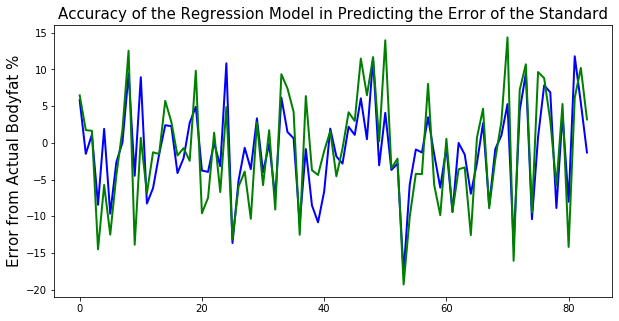

In [171]:
x = range(0,84)
y1 = inverse_lasso_y_test
y2 = inverse_y_test

plt.figure(figsize=(10, 5))
plt.plot(x, y1, color='blue', linewidth=2, label='Predicted Error')
plt.plot(x, y2, color='green', linewidth=2, label='Actual Error')
plt.ylabel('Error from Actual Bodyfat %', fontsize=15)
plt.title('Accuracy of the Regression Model in Predicting the Error of the Standard', fontsize=15)
plt.savefig
plt.show();

###### Ridge

In [112]:
inverse_ridge_y_train = scale_y.inverse_transform(err_y_h_ridge_train)
inverse_ridge_y_test = scale_y.inverse_transform(err_y_h_ridge_test)

In [113]:
ridge_test_mean_error = np.sqrt(mean_squared_error(inverse_y_test, inverse_ridge_y_test))
ridge_train_mean_error = np.sqrt(mean_squared_error(inverse_y_train, inverse_ridge_y_train))

In [115]:
print(ridge_test_mean_error)
print(ridge_train_mean_error)

4.113036216994409
3.700394050691321


### Random Forest Regressor

#### ERROR

##### Feature Importances

In [ ]:
tree_clf = RandomForestRegressor(n_estimators=150, max_depth=6, max_features=3, min_samples_leaf=3, min_samples_split=8, random_state=0) 
tree_clf.fit(RF_err_X_train, RF_err_y_train.values.ravel())

In [ ]:
y_pred = tree_clf.predict(RF_err_X_test)

In [ ]:
mse = mean_squared_error(RF_err_y_test, y_pred)
r2 = r2_score(RF_err_y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)
print(r2)

In [ ]:
tree_clf.feature_importances_

In [ ]:
def plot_feature_importances(model):
    n_features = RF_err_X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), RF_err_X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

##### RandomForest GridSearchCV

In [ ]:
param_grid={
            'max_depth': range(3,12),
            'n_estimators': (10, 20, 30, 40, 50, 60, 70, 80, 90),
            'min_samples_split': (2,3,4),
            'bootstrap': [True],
            'max_samples': (30,40),
        },

In [ ]:
gsc = GridSearchCV(estimator=RandomForestRegressor(),
        param_grid = param_grid,
        verbose=0, cv=3)

In [ ]:
grid_result = gsc.fit(RF_err_X_train, RF_err_y_train.values.ravel())
best_params = grid_result.best_params_
grid_result.best_score_

In [ ]:
best_params

In [ ]:
gsc_errors_predictions = grid_result.predict(RF_err_X_test)
gsc_errors_scores = abs(gsc_errors_predictions - RF_err_y_test.values.ravel())
total_gsc_error = sum(gsc_errors_scores)
max_gsc_error = max(gsc_errors_scores)
mean_gsc_error = np.mean(gsc_errors_scores)
print(total_gsc_error)
print(max_gsc_error)
print(mean_gsc_error)

In [ ]:
err_rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], min_samples_split=best_params["min_samples_split"], max_samples=best_params["max_samples"], bootstrap=best_params["bootstrap"], random_state=0, verbose=0)

In [ ]:
err_rfr_result = err_rfr.fit(RF_err_X_train, RF_err_y_train.values.ravel())
err_rfr_errors_predictions = err_rfr.predict(RF_err_X_test)
err_rfr_errors_scores = abs(err_rfr_errors_predictions - RF_err_y_test.values.ravel())
total_err_rfr_error = sum(err_rfr_errors_scores)
max_err_rfr_error = max(err_rfr_errors_scores)
mean_err_rfr_error = np.mean(err_rfr_errors_scores)
print(total_err_rfr_error)
print(max_err_rfr_error)
print(mean_err_rfr_error)

##### Attempt at CV?

In [ ]:
rfr_cval_score = cross_val_score(rfr, RF_err_X_train, RF_err_y_train.values.ravel(), cv=4)
mean_rfr_cval_score = rfr_cval_score.mean()
print(mean_rfr_cval_score)

##### Attempt at RandomizedCV

#### BODYFAT

##### Feature Importances

In [ ]:
BF_tree_clf = RandomForestRegressor(n_estimators=150, max_depth=6, max_features=3, min_samples_leaf=3, min_samples_split=8, random_state=0) 
BF_tree_clf.fit(RF_BF_X_train, RF_BF_y_train.values.ravel())

In [ ]:
y_pred = BF_tree_clf.predict(RF_BF_X_test)

In [ ]:
mse = mean_squared_error(RF_BF_y_test, y_pred)
r2 = r2_score(RF_BF_y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)
print(r2)

In [ ]:
BF_tree_clf.feature_importances_

def plot_feature_importances(model):
    n_features = RF_BF_X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), RF_BF_X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [ ]:
plot_feature_importances(BF_tree_clf)

##### RandomForest GridSearchCV

In [ ]:
param_grid={
            'max_depth': range(3,12),
            'n_estimators': (10, 20, 30, 40, 50, 60, 70, 80, 90),
            'min_samples_split': (2,3,4),
            'bootstrap': [True],
            'max_samples': (30,40),
        },

In [ ]:
BF_gsc = GridSearchCV(estimator=RandomForestRegressor(),
        param_grid = param_grid,
        verbose=0, cv=3)

In [ ]:
grid_result = BF_gsc.fit(RF_BF_X_train, RF_BF_y_train.values.ravel())
best_params = grid_result.best_params_
grid_result.best_score_

In [ ]:
best_params

In [ ]:
BF_gsc_predictions = grid_result.predict(RF_BF_X_test)
BF_gsc_scores = abs(BF_gsc_predictions - RF_BF_y_test.values.ravel())
total_BF_gsc_error = sum(BF_gsc_scores)
max_BF_gsc_error = max(BF_gsc_scores)
mean_BF_gsc_error = np.mean(BF_gsc_scores)
print(total_BF_gsc_error)
print(max_BF_gsc_error)
print(mean_BF_gsc_error)

In [ ]:
BF_rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], min_samples_split=best_params["min_samples_split"], max_samples=best_params["max_samples"], bootstrap=best_params["bootstrap"], random_state=0, verbose=0)

In [ ]:
BF_rfr_result = BF_rfr.fit(RF_BF_X_train, RF_BF_y_train.values.ravel())
BF_rfr_errors_predictions = BF_rfr.predict(RF_BF_X_test)
BF_rfr_errors_scores = abs(BF_rfr_errors_predictions - RF_BF_y_test.values.ravel())
total_BF_rfr_error = sum(BF_rfr_errors_scores)
max_BF_rfr_error = max(BF_rfr_errors_scores)
mean_BF_rfr_error = np.mean(BF_rfr_errors_scores)
print(total_BF_rfr_error)
print(max_BF_rfr_error)
print(mean_BF_rfr_error)

### XgB Regressor

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

#### ERROR

In [ ]:
xgbr1 = xgb.XGBRegressor(verbosity=0)
xgbr1.fit(RF_err_X_train, RF_err_y_train)
score1 = xgbr1.score(RF_err_X_train, RF_err_y_train)
score2 = xgbr1.score(RF_err_X_test, RF_err_y_test)
print(score1)
print(score2)

In [ ]:
ypred1 = xgbr1.predict(RF_err_X_test)
mse1 = mean_squared_error(RF_err_y_test, ypred1)
print("MSE: %.2f" % mse1)

print("RMSE: %.2f" % (mse1*(1/2.0)))

In [ ]:
scores = cross_val_score(xgbr1, RF_err_X_train, RF_err_y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr1, RF_err_X_train, RF_err_y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

In [ ]:
x_ax = range(len(RF_err_y_test))
plt.plot(x_ax, RF_err_y_test, label="original")
plt.plot(x_ax, ypred1, label="predicted")
plt.title("Real vs Predicted")
plt.legend()
plt.show()

#### BODYFAT

In [ ]:
xgbr2 = xgb.XGBRegressor(verbosity=0)
xgbr2.fit(RF_BF_X_train, RF_BF_y_train)
score1 = xgbr2.score(RF_BF_X_train, RF_BF_y_train)
score2 = xgbr2.score(RF_BF_X_test, RF_BF_y_test)
print(score1)
print(score2)

In [ ]:
ypred2 = xgbr2.predict(RF_BF_X_test)
mse2 = mean_squared_error(RF_BF_y_test, ypred2)
print("MSE: %.2f" % mse1)
print("RMSE: %.2f" % (mse1*(1/2.0)))

In [ ]:
scores = cross_val_score(xgbr2, RF_BF_X_train, RF_BF_y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr2, RF_BF_X_train, RF_BF_y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

In [ ]:
x_ax = range(len(RF_BF_y_test))
plt.plot(x_ax, RF_BF_y_test, label="original")
plt.plot(x_ax, ypred2, label="predicted")
plt.title("Real vs Predicted")
plt.legend()
plt.show()

## Conclusion

The Lasso Linear Regression model used to predict the Error rate of the current method of measurement resulted in the most accurate predictions of body fat in the adult males from this study.

### Comparing the DoD measurements to the Lasso Regression Measurements

The models must beat the current average error of 7.22 with range of 0.03 - 25.45 for the DoD measurements

Lasso and Regression both came out with an almost equal accuracy rate of predicting the Error


Thus, the solution is this { [DoD Bodyfat Estimation] - [Model Prediction of Error] = [A more accurate Estimation] }

In [122]:
#Pulling the results
#Lasso
print(f'Lasso average test error: {round(lasso_test_mean_error, 2)}')
print(f'Lasso average train erorr: {round(lasso_train_mean_error, 2)}')
#Ridge
print(f'Ridge average test erorr: {round(ridge_test_mean_error, 2)}')
print(f'Ridge average train erorr: {round(ridge_train_mean_error, 2)}')

Lasso average test error: 4.12
Lasso average train erorr: 3.67
Ridge average test erorr: 4.11
Ridge average train erorr: 3.7


The models above show a much closer rate of accuracy, although still not the ideal